In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=0)

# データセット作成

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

_StoreTrueAction(option_strings=['-label_smoothing'], dest='label_smoothing', nargs=0, const=True, default=False, type=None, choices=None, help=None, metavar=None)

In [20]:
opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', './output', '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [21]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [22]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [23]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [24]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Transformer モデルの実装と実体化

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        return dec_output, dec_slf_attn, dec_enc_attn

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []

        if return_attns:
            return enc_output, enc_slf_attn_list
        return enc_output,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []

        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, *_ = self.encoder(src_seq, src_mask)
        dec_output, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2))

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing):
    ''' Epoch operation in training phase'''

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 

    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing) 
        loss.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy


def eval_epoch(model, validation_data, device, opt):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)

            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt)

[Info] Training performance will be written to file: ./output/train.log and ./output/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9491.08980, accuracy: 0.003 %, lr:  0.00000, elapse: 0.276 min


  - (Validation) ppl:  9467.92846, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9461.25669, accuracy: 0.122 %, lr:  0.00000, elapse: 0.284 min


  - (Validation) ppl:  9410.43518, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9405.58603, accuracy: 7.140 %, lr:  0.00000, elapse: 0.276 min


  - (Validation) ppl:  9328.43187, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9337.43520, accuracy: 11.970 %, lr:  0.00000, elapse: 0.278 min


  - (Validation) ppl:  9244.74202, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9272.57114, accuracy: 12.015 %, lr:  0.00000, elapse: 0.277 min


  - (Validation) ppl:  9173.35223, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9216.39223, accuracy: 12.015 %, lr:  0.00000, elapse: 0.281 min


  - (Validation) ppl:  9113.32012, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9168.53236, accuracy: 12.015 %, lr:  0.00000, elapse: 0.280 min


  - (Validation) ppl:  9063.45340, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9128.90423, accuracy: 12.015 %, lr:  0.00000, elapse: 0.278 min


  - (Validation) ppl:  9024.00654, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9096.35738, accuracy: 12.015 %, lr:  0.00000, elapse: 0.279 min


  - (Validation) ppl:  8992.81888, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9068.38380, accuracy: 12.015 %, lr:  0.00000, elapse: 0.284 min


  - (Validation) ppl:  8966.31239, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9042.72832, accuracy: 12.015 %, lr:  0.00000, elapse: 0.284 min


  - (Validation) ppl:  8940.60715, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9016.88564, accuracy: 12.015 %, lr:  0.00000, elapse: 0.284 min


  - (Validation) ppl:  8909.61855, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  8985.11076, accuracy: 12.015 %, lr:  0.00000, elapse: 0.287 min


  - (Validation) ppl:  8867.64539, accuracy: 12.528 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  8944.03564, accuracy: 13.063 %, lr:  0.00000, elapse: 0.294 min


  - (Validation) ppl:  8829.34212, accuracy: 15.644 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  8901.99816, accuracy: 16.184 %, lr:  0.00000, elapse: 0.285 min


  - (Validation) ppl:  8786.29953, accuracy: 16.240 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8864.01442, accuracy: 17.058 %, lr:  0.00000, elapse: 0.283 min


  - (Validation) ppl:  8746.48771, accuracy: 17.445 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8829.14993, accuracy: 17.549 %, lr:  0.00000, elapse: 0.281 min


  - (Validation) ppl:  8713.96290, accuracy: 17.029 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8795.91809, accuracy: 17.850 %, lr:  0.00000, elapse: 0.281 min


  - (Validation) ppl:  8676.55817, accuracy: 17.181 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8763.31276, accuracy: 17.986 %, lr:  0.00000, elapse: 0.283 min


  - (Validation) ppl:  8640.50131, accuracy: 17.417 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8730.51858, accuracy: 18.062 %, lr:  0.00000, elapse: 0.282 min


  - (Validation) ppl:  8606.87806, accuracy: 17.410 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8697.47439, accuracy: 18.071 %, lr:  0.00000, elapse: 0.282 min


  - (Validation) ppl:  8565.84216, accuracy: 17.659 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8663.73148, accuracy: 18.074 %, lr:  0.00000, elapse: 0.279 min


  - (Validation) ppl:  8530.87770, accuracy: 17.618 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8628.78230, accuracy: 18.098 %, lr:  0.00000, elapse: 0.280 min


  - (Validation) ppl:  8484.98758, accuracy: 18.179 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8592.67025, accuracy: 18.091 %, lr:  0.00000, elapse: 0.280 min


  - (Validation) ppl:  8444.98058, accuracy: 18.234 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8555.36931, accuracy: 18.070 %, lr:  0.00000, elapse: 0.278 min


  - (Validation) ppl:  8400.62735, accuracy: 18.400 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8516.42808, accuracy: 18.073 %, lr:  0.00000, elapse: 0.282 min


  - (Validation) ppl:  8358.05796, accuracy: 18.303 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8475.82605, accuracy: 18.098 %, lr:  0.00000, elapse: 0.282 min


  - (Validation) ppl:  8311.58417, accuracy: 18.373 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8434.08030, accuracy: 18.064 %, lr:  0.00000, elapse: 0.281 min


  - (Validation) ppl:  8268.94031, accuracy: 18.213 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8390.47866, accuracy: 18.083 %, lr:  0.00000, elapse: 0.280 min


  - (Validation) ppl:  8216.48035, accuracy: 18.352 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8345.89396, accuracy: 18.060 %, lr:  0.00000, elapse: 0.286 min


  - (Validation) ppl:  8162.42313, accuracy: 18.580 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8299.55265, accuracy: 18.036 %, lr:  0.00000, elapse: 0.279 min


  - (Validation) ppl:  8109.65606, accuracy: 18.684 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8251.69308, accuracy: 18.014 %, lr:  0.00000, elapse: 0.278 min


  - (Validation) ppl:  8055.45610, accuracy: 18.608 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8202.44703, accuracy: 18.001 %, lr:  0.00000, elapse: 0.283 min


  - (Validation) ppl:  8003.04495, accuracy: 18.546 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8151.82447, accuracy: 17.968 %, lr:  0.00000, elapse: 0.288 min


  - (Validation) ppl:  7945.86385, accuracy: 18.615 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8099.54937, accuracy: 17.957 %, lr:  0.00000, elapse: 0.286 min


  - (Validation) ppl:  7885.39160, accuracy: 18.698 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8045.93773, accuracy: 17.932 %, lr:  0.00000, elapse: 0.281 min


  - (Validation) ppl:  7824.13282, accuracy: 18.636 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  7991.01021, accuracy: 17.879 %, lr:  0.00000, elapse: 0.280 min


  - (Validation) ppl:  7762.97193, accuracy: 18.615 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  7934.84241, accuracy: 17.840 %, lr:  0.00000, elapse: 0.279 min


  - (Validation) ppl:  7701.75783, accuracy: 18.691 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7877.44016, accuracy: 17.793 %, lr:  0.00000, elapse: 0.280 min


  - (Validation) ppl:  7637.10837, accuracy: 18.691 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7818.84285, accuracy: 17.727 %, lr:  0.00000, elapse: 0.282 min


  - (Validation) ppl:  7574.00752, accuracy: 18.705 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7758.98423, accuracy: 17.704 %, lr:  0.00000, elapse: 0.279 min


  - (Validation) ppl:  7506.70724, accuracy: 18.663 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7698.04055, accuracy: 17.649 %, lr:  0.00000, elapse: 0.278 min


  - (Validation) ppl:  7436.90213, accuracy: 18.532 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7635.89114, accuracy: 17.599 %, lr:  0.00000, elapse: 0.286 min


  - (Validation) ppl:  7368.81451, accuracy: 18.490 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7572.95135, accuracy: 17.568 %, lr:  0.00000, elapse: 0.289 min


  - (Validation) ppl:  7298.65076, accuracy: 17.680 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7509.09236, accuracy: 17.467 %, lr:  0.00000, elapse: 0.290 min


  - (Validation) ppl:  7228.47652, accuracy: 18.296 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7443.72720, accuracy: 17.464 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  7156.65923, accuracy: 18.296 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7377.98977, accuracy: 17.337 %, lr:  0.00001, elapse: 0.277 min


  - (Validation) ppl:  7083.45502, accuracy: 17.888 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7310.79191, accuracy: 17.286 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  7010.12153, accuracy: 18.470 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7242.97640, accuracy: 17.211 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  6935.63889, accuracy: 17.507 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7174.49729, accuracy: 17.125 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  6860.89150, accuracy: 16.911 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7104.99690, accuracy: 17.085 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  6784.87717, accuracy: 17.860 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7034.75915, accuracy: 17.004 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  6708.20777, accuracy: 17.001 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  6964.10462, accuracy: 16.863 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  6630.87268, accuracy: 18.386 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6892.55188, accuracy: 16.837 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  6553.48771, accuracy: 16.849 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6820.27169, accuracy: 16.749 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  6474.09972, accuracy: 16.960 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6747.27983, accuracy: 16.682 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  6395.12499, accuracy: 16.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6673.74928, accuracy: 16.614 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  6314.46202, accuracy: 17.867 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6599.71374, accuracy: 16.524 %, lr:  0.00001, elapse: 0.284 min


  - (Validation) ppl:  6236.16928, accuracy: 15.997 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6525.02426, accuracy: 16.392 %, lr:  0.00001, elapse: 0.276 min


  - (Validation) ppl:  6152.86069, accuracy: 16.994 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6449.77712, accuracy: 16.397 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  6069.64857, accuracy: 17.978 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6373.89439, accuracy: 16.275 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  5987.50675, accuracy: 17.168 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6297.43710, accuracy: 16.220 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  5903.11577, accuracy: 17.292 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6220.95196, accuracy: 16.168 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  5818.84533, accuracy: 18.324 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6144.01869, accuracy: 16.152 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  5734.78185, accuracy: 18.518 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6066.82483, accuracy: 16.035 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  5651.58576, accuracy: 18.504 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  5988.76338, accuracy: 16.175 %, lr:  0.00001, elapse: 0.283 min


  - (Validation) ppl:  5567.39430, accuracy: 19.155 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5911.27542, accuracy: 16.163 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  5485.00602, accuracy: 19.114 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5833.62025, accuracy: 16.126 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  5401.75571, accuracy: 19.120 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5755.69226, accuracy: 16.078 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  5320.06685, accuracy: 19.488 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5677.48607, accuracy: 16.157 %, lr:  0.00001, elapse: 0.283 min


  - (Validation) ppl:  5239.06626, accuracy: 18.726 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5599.17801, accuracy: 16.232 %, lr:  0.00001, elapse: 0.284 min


  - (Validation) ppl:  5155.86115, accuracy: 19.190 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5521.15453, accuracy: 16.255 %, lr:  0.00001, elapse: 0.288 min


  - (Validation) ppl:  5074.29731, accuracy: 19.224 %, lr:  0.00001, elapse: 0.008 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5442.59986, accuracy: 16.292 %, lr:  0.00001, elapse: 0.287 min


  - (Validation) ppl:  4992.69190, accuracy: 18.934 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5364.55842, accuracy: 16.300 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  4911.45280, accuracy: 19.003 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5286.54643, accuracy: 16.350 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  4830.27058, accuracy: 19.217 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5208.68686, accuracy: 16.358 %, lr:  0.00001, elapse: 0.278 min


  - (Validation) ppl:  4749.86869, accuracy: 19.030 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5130.83650, accuracy: 16.446 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  4669.62008, accuracy: 18.892 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5053.20784, accuracy: 16.485 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  4589.27328, accuracy: 19.079 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  4975.60760, accuracy: 16.598 %, lr:  0.00001, elapse: 0.276 min


  - (Validation) ppl:  4509.78066, accuracy: 19.266 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4898.51060, accuracy: 16.642 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  4431.28136, accuracy: 18.767 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4822.04857, accuracy: 16.649 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  4351.90873, accuracy: 19.065 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4745.41684, accuracy: 16.747 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  4273.83064, accuracy: 18.830 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4669.06713, accuracy: 16.812 %, lr:  0.00001, elapse: 0.288 min


  - (Validation) ppl:  4196.15659, accuracy: 18.920 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4593.33838, accuracy: 16.844 %, lr:  0.00001, elapse: 0.286 min


  - (Validation) ppl:  4119.18880, accuracy: 18.691 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4517.69194, accuracy: 16.914 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  4042.30506, accuracy: 18.726 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4442.92581, accuracy: 16.956 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  3965.44331, accuracy: 18.947 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4368.30963, accuracy: 17.009 %, lr:  0.00001, elapse: 0.286 min


  - (Validation) ppl:  3890.15248, accuracy: 18.920 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4294.01354, accuracy: 17.067 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  3815.33842, accuracy: 18.947 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4220.44845, accuracy: 17.148 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  3741.29412, accuracy: 18.684 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4147.18497, accuracy: 17.199 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  3667.87209, accuracy: 18.663 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4074.63106, accuracy: 17.223 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  3594.68300, accuracy: 18.705 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4002.76525, accuracy: 17.285 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  3522.91527, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3931.26783, accuracy: 17.315 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  3451.03685, accuracy: 18.719 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3860.55350, accuracy: 17.319 %, lr:  0.00001, elapse: 0.286 min


  - (Validation) ppl:  3380.61126, accuracy: 18.705 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3790.19495, accuracy: 17.425 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  3310.76116, accuracy: 18.691 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3720.66125, accuracy: 17.468 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  3241.41417, accuracy: 18.712 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3651.74931, accuracy: 17.485 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  3173.46736, accuracy: 18.663 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3583.44951, accuracy: 17.555 %, lr:  0.00001, elapse: 0.283 min


  - (Validation) ppl:  3106.77676, accuracy: 18.663 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3515.91877, accuracy: 17.535 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  3039.07790, accuracy: 18.663 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3449.10930, accuracy: 17.548 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  2973.78245, accuracy: 18.657 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3382.91764, accuracy: 17.615 %, lr:  0.00001, elapse: 0.287 min


  - (Validation) ppl:  2909.05246, accuracy: 18.670 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3317.60923, accuracy: 17.637 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  2844.40458, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3253.01296, accuracy: 17.675 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  2782.15054, accuracy: 18.663 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3189.21373, accuracy: 17.636 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  2719.37000, accuracy: 18.670 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3126.22875, accuracy: 17.679 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  2658.43399, accuracy: 18.657 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3063.89511, accuracy: 17.683 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  2597.73250, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3002.44798, accuracy: 17.720 %, lr:  0.00001, elapse: 0.287 min


  - (Validation) ppl:  2538.70684, accuracy: 18.670 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2941.93081, accuracy: 17.675 %, lr:  0.00001, elapse: 0.278 min


  - (Validation) ppl:  2479.71798, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2881.90931, accuracy: 17.733 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  2423.02577, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2823.04289, accuracy: 17.693 %, lr:  0.00001, elapse: 0.283 min


  - (Validation) ppl:  2366.14422, accuracy: 18.670 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2764.88673, accuracy: 17.737 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  2310.23424, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2707.46440, accuracy: 17.842 %, lr:  0.00001, elapse: 0.284 min


  - (Validation) ppl:  2255.28478, accuracy: 18.677 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2651.05846, accuracy: 17.802 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  2201.94606, accuracy: 18.670 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2595.38467, accuracy: 17.783 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  2149.38561, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2540.63516, accuracy: 17.802 %, lr:  0.00001, elapse: 0.289 min


  - (Validation) ppl:  2097.20023, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2486.67927, accuracy: 17.845 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  2046.13020, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2433.68042, accuracy: 17.832 %, lr:  0.00001, elapse: 0.278 min


  - (Validation) ppl:  1996.43180, accuracy: 18.677 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2381.55827, accuracy: 17.889 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  1947.59698, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2330.12659, accuracy: 17.963 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  1899.23935, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2279.69085, accuracy: 17.913 %, lr:  0.00001, elapse: 0.290 min


  - (Validation) ppl:  1852.10044, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2230.18106, accuracy: 17.956 %, lr:  0.00001, elapse: 0.288 min


  - (Validation) ppl:  1805.95368, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2181.37143, accuracy: 18.072 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  1760.75045, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2133.54528, accuracy: 18.031 %, lr:  0.00001, elapse: 0.278 min


  - (Validation) ppl:  1716.96568, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2086.61860, accuracy: 18.077 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  1673.58957, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2040.47916, accuracy: 18.137 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  1630.98805, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  1995.16367, accuracy: 18.118 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  1589.46408, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1950.81575, accuracy: 18.165 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  1548.60931, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1907.23730, accuracy: 18.184 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  1509.04630, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1864.58017, accuracy: 18.251 %, lr:  0.00001, elapse: 0.285 min


  - (Validation) ppl:  1469.95472, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1822.54215, accuracy: 18.313 %, lr:  0.00001, elapse: 0.281 min


  - (Validation) ppl:  1432.28799, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1781.48407, accuracy: 18.320 %, lr:  0.00001, elapse: 0.282 min


  - (Validation) ppl:  1394.80631, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1741.20597, accuracy: 18.360 %, lr:  0.00001, elapse: 0.280 min


  - (Validation) ppl:  1358.42309, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1701.82700, accuracy: 18.346 %, lr:  0.00001, elapse: 0.278 min


  - (Validation) ppl:  1323.04761, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1663.18144, accuracy: 18.420 %, lr:  0.00001, elapse: 0.279 min


  - (Validation) ppl:  1288.46822, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1625.33296, accuracy: 18.419 %, lr:  0.00001, elapse: 0.276 min


  - (Validation) ppl:  1254.44881, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1588.39043, accuracy: 18.471 %, lr:  0.00001, elapse: 0.287 min


  - (Validation) ppl:  1221.92178, accuracy: 18.677 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1552.23343, accuracy: 18.437 %, lr:  0.00002, elapse: 0.288 min


  - (Validation) ppl:  1189.80358, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1516.72499, accuracy: 18.497 %, lr:  0.00002, elapse: 0.289 min


  - (Validation) ppl:  1157.94963, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1482.12943, accuracy: 18.501 %, lr:  0.00002, elapse: 0.287 min


  - (Validation) ppl:  1127.41472, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1448.10651, accuracy: 18.531 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  1097.38099, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1415.03030, accuracy: 18.522 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  1068.30656, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1382.58787, accuracy: 18.537 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  1039.76080, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1350.92391, accuracy: 18.552 %, lr:  0.00002, elapse: 0.289 min


  - (Validation) ppl:  1012.09169, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1319.92433, accuracy: 18.594 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  985.06001, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1289.63202, accuracy: 18.590 %, lr:  0.00002, elapse: 0.281 min


  - (Validation) ppl:  959.04525, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1260.02793, accuracy: 18.590 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  933.37180, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1231.22167, accuracy: 18.585 %, lr:  0.00002, elapse: 0.278 min


  - (Validation) ppl:  908.29298, accuracy: 18.677 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1203.03890, accuracy: 18.609 %, lr:  0.00002, elapse: 0.278 min


  - (Validation) ppl:  884.07644, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1175.48865, accuracy: 18.629 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  860.54839, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1148.61587, accuracy: 18.633 %, lr:  0.00002, elapse: 0.287 min


  - (Validation) ppl:  837.60774, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1122.47851, accuracy: 18.632 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  815.15273, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1096.95568, accuracy: 18.646 %, lr:  0.00002, elapse: 0.285 min


  - (Validation) ppl:  793.46432, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1071.98254, accuracy: 18.646 %, lr:  0.00002, elapse: 0.288 min


  - (Validation) ppl:  772.36258, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1047.71236, accuracy: 18.636 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  751.83036, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1023.99264, accuracy: 18.662 %, lr:  0.00002, elapse: 0.277 min


  - (Validation) ppl:  731.90593, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1000.97214, accuracy: 18.659 %, lr:  0.00002, elapse: 0.283 min


  - (Validation) ppl:  712.54229, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  978.44898, accuracy: 18.669 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  693.70315, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  956.60058, accuracy: 18.660 %, lr:  0.00002, elapse: 0.283 min


  - (Validation) ppl:  675.42659, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  935.26348, accuracy: 18.674 %, lr:  0.00002, elapse: 0.290 min


  - (Validation) ppl:  657.64845, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  914.53369, accuracy: 18.670 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  640.45693, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  894.36259, accuracy: 18.678 %, lr:  0.00002, elapse: 0.284 min


  - (Validation) ppl:  623.74012, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  874.71274, accuracy: 18.682 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  607.51354, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  855.60325, accuracy: 18.691 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  591.74591, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  837.02732, accuracy: 18.683 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  576.53988, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  818.97088, accuracy: 18.695 %, lr:  0.00002, elapse: 0.285 min


  - (Validation) ppl:  561.69921, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  801.46741, accuracy: 18.687 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  547.47451, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  784.38235, accuracy: 18.703 %, lr:  0.00002, elapse: 0.278 min


  - (Validation) ppl:  533.60340, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  767.82133, accuracy: 18.703 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  520.09626, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  751.72525, accuracy: 18.708 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  507.11674, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  736.11254, accuracy: 18.704 %, lr:  0.00002, elapse: 0.281 min


  - (Validation) ppl:  494.56280, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  720.92760, accuracy: 18.710 %, lr:  0.00002, elapse: 0.284 min


  - (Validation) ppl:  482.31573, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  706.16405, accuracy: 18.708 %, lr:  0.00002, elapse: 0.285 min


  - (Validation) ppl:  470.50887, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  691.86360, accuracy: 18.718 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  459.03425, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  677.95121, accuracy: 18.716 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  447.96051, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  664.48043, accuracy: 18.718 %, lr:  0.00002, elapse: 0.277 min


  - (Validation) ppl:  437.23020, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  651.39427, accuracy: 18.718 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  426.89755, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  638.71510, accuracy: 18.722 %, lr:  0.00002, elapse: 0.278 min


  - (Validation) ppl:  416.83851, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  626.44175, accuracy: 18.719 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  407.11153, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  614.54169, accuracy: 18.715 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  397.79087, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  602.99738, accuracy: 18.716 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  388.67246, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  591.77836, accuracy: 18.724 %, lr:  0.00002, elapse: 0.278 min


  - (Validation) ppl:  379.97177, accuracy: 18.677 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  580.93775, accuracy: 18.727 %, lr:  0.00002, elapse: 0.278 min


  - (Validation) ppl:  371.43229, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  570.46072, accuracy: 18.723 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  363.34333, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  560.32278, accuracy: 18.723 %, lr:  0.00002, elapse: 0.281 min


  - (Validation) ppl:  355.38429, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  550.49072, accuracy: 18.729 %, lr:  0.00002, elapse: 0.287 min


  - (Validation) ppl:  347.80248, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  541.00186, accuracy: 18.733 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  340.41612, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  531.85329, accuracy: 18.731 %, lr:  0.00002, elapse: 0.289 min


  - (Validation) ppl:  333.37704, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  522.96456, accuracy: 18.735 %, lr:  0.00002, elapse: 0.289 min


  - (Validation) ppl:  326.47751, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  514.42344, accuracy: 18.740 %, lr:  0.00002, elapse: 0.289 min


  - (Validation) ppl:  319.87692, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  506.17350, accuracy: 18.733 %, lr:  0.00002, elapse: 0.288 min


  - (Validation) ppl:  313.53782, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  498.23314, accuracy: 18.737 %, lr:  0.00002, elapse: 0.290 min


  - (Validation) ppl:  307.43653, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  490.57083, accuracy: 18.740 %, lr:  0.00002, elapse: 0.287 min


  - (Validation) ppl:  301.53560, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  483.19895, accuracy: 18.739 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  295.91006, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  476.09599, accuracy: 18.743 %, lr:  0.00002, elapse: 0.285 min


  - (Validation) ppl:  290.51307, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  469.26325, accuracy: 18.741 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  285.24299, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  462.63409, accuracy: 18.741 %, lr:  0.00002, elapse: 0.282 min


  - (Validation) ppl:  280.06805, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  456.22710, accuracy: 18.743 %, lr:  0.00002, elapse: 0.284 min


  - (Validation) ppl:  275.25664, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  449.86234, accuracy: 18.751 %, lr:  0.00002, elapse: 0.278 min


  - (Validation) ppl:  270.57393, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  443.83970, accuracy: 18.749 %, lr:  0.00002, elapse: 0.284 min


  - (Validation) ppl:  265.96864, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  437.87452, accuracy: 18.749 %, lr:  0.00002, elapse: 0.281 min


  - (Validation) ppl:  261.84461, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  432.03405, accuracy: 18.753 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  258.13337, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  426.46685, accuracy: 18.756 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  253.00541, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  420.88856, accuracy: 18.753 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  249.10826, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  415.53120, accuracy: 18.754 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  245.35496, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  410.23638, accuracy: 18.756 %, lr:  0.00002, elapse: 0.284 min


  - (Validation) ppl:  241.94798, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  405.14539, accuracy: 18.754 %, lr:  0.00002, elapse: 0.287 min


  - (Validation) ppl:  237.66219, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  400.11769, accuracy: 18.756 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  233.86266, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  395.32487, accuracy: 18.757 %, lr:  0.00002, elapse: 0.288 min


  - (Validation) ppl:  230.54896, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  390.48962, accuracy: 18.763 %, lr:  0.00002, elapse: 0.285 min


  - (Validation) ppl:  227.54397, accuracy: 18.677 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  385.96967, accuracy: 18.779 %, lr:  0.00002, elapse: 0.287 min


  - (Validation) ppl:  224.26161, accuracy: 18.684 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  381.35281, accuracy: 18.799 %, lr:  0.00002, elapse: 0.290 min


  - (Validation) ppl:  220.78696, accuracy: 18.719 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  376.91067, accuracy: 18.869 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  217.41596, accuracy: 18.698 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  372.52774, accuracy: 18.951 %, lr:  0.00002, elapse: 0.292 min


  - (Validation) ppl:  214.18680, accuracy: 18.740 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  368.18364, accuracy: 19.096 %, lr:  0.00002, elapse: 0.287 min


  - (Validation) ppl:  211.79541, accuracy: 19.051 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  363.93569, accuracy: 19.405 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  208.40553, accuracy: 19.841 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  359.66861, accuracy: 19.798 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  205.76607, accuracy: 19.972 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  355.52257, accuracy: 20.179 %, lr:  0.00002, elapse: 0.276 min


  - (Validation) ppl:  202.52331, accuracy: 19.363 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  351.39696, accuracy: 20.590 %, lr:  0.00002, elapse: 0.277 min


  - (Validation) ppl:  199.58379, accuracy: 20.693 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  347.14730, accuracy: 20.880 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  196.49942, accuracy: 22.438 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  342.85068, accuracy: 21.374 %, lr:  0.00002, elapse: 0.281 min


  - (Validation) ppl:  193.95224, accuracy: 20.845 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  338.56650, accuracy: 21.625 %, lr:  0.00002, elapse: 0.280 min


  - (Validation) ppl:  190.69333, accuracy: 21.738 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  334.41976, accuracy: 22.079 %, lr:  0.00002, elapse: 0.279 min


  - (Validation) ppl:  187.36750, accuracy: 21.828 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  330.14884, accuracy: 22.273 %, lr:  0.00002, elapse: 0.293 min


  - (Validation) ppl:  184.50206, accuracy: 21.011 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  326.11585, accuracy: 22.659 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  181.89475, accuracy: 22.812 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  321.85847, accuracy: 22.802 %, lr:  0.00002, elapse: 0.286 min


  - (Validation) ppl:  178.94864, accuracy: 21.503 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  317.86580, accuracy: 23.121 %, lr:  0.00002, elapse: 0.291 min


  - (Validation) ppl:  176.69277, accuracy: 23.359 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  313.84698, accuracy: 23.233 %, lr:  0.00002, elapse: 0.292 min


  - (Validation) ppl:  174.45910, accuracy: 23.947 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  309.75738, accuracy: 23.536 %, lr:  0.00003, elapse: 0.289 min


  - (Validation) ppl:  172.03285, accuracy: 23.483 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  305.74461, accuracy: 23.634 %, lr:  0.00003, elapse: 0.285 min


  - (Validation) ppl:  168.90549, accuracy: 23.892 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  301.80310, accuracy: 23.663 %, lr:  0.00003, elapse: 0.288 min


  - (Validation) ppl:  166.04880, accuracy: 24.093 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  297.79563, accuracy: 23.920 %, lr:  0.00003, elapse: 0.291 min


  - (Validation) ppl:  164.12190, accuracy: 23.283 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  293.79611, accuracy: 24.031 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  161.71657, accuracy: 24.266 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  289.86211, accuracy: 24.192 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  159.07619, accuracy: 24.584 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  285.94128, accuracy: 24.332 %, lr:  0.00003, elapse: 0.285 min


  - (Validation) ppl:  156.85026, accuracy: 24.598 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  281.97637, accuracy: 24.417 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  153.50100, accuracy: 24.612 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  278.12332, accuracy: 24.505 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  150.98479, accuracy: 24.751 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  274.17501, accuracy: 24.568 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  148.28631, accuracy: 24.612 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  270.39446, accuracy: 24.597 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  146.32891, accuracy: 24.647 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  266.48553, accuracy: 24.624 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  143.77795, accuracy: 24.584 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  262.61188, accuracy: 24.673 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  141.59227, accuracy: 24.765 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  258.93104, accuracy: 24.722 %, lr:  0.00003, elapse: 0.284 min


  - (Validation) ppl:  138.57940, accuracy: 24.799 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  255.12085, accuracy: 24.736 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  136.14332, accuracy: 24.792 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  251.25927, accuracy: 24.769 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  134.36111, accuracy: 24.903 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  247.77906, accuracy: 24.830 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  131.86160, accuracy: 24.771 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  244.05422, accuracy: 24.923 %, lr:  0.00003, elapse: 0.283 min


  - (Validation) ppl:  129.30123, accuracy: 25.028 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  240.36847, accuracy: 24.996 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  127.16457, accuracy: 25.035 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  236.82624, accuracy: 25.161 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  126.38869, accuracy: 25.575 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  233.14461, accuracy: 25.376 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  122.92203, accuracy: 25.499 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  229.72503, accuracy: 25.625 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  121.61759, accuracy: 25.900 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  226.27572, accuracy: 25.939 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  118.98957, accuracy: 26.447 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  222.96442, accuracy: 26.335 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  116.85735, accuracy: 26.413 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  219.59028, accuracy: 26.632 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  114.48261, accuracy: 26.884 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  216.29435, accuracy: 26.954 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  113.37837, accuracy: 27.361 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  213.18901, accuracy: 27.356 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  111.60949, accuracy: 27.542 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  209.92481, accuracy: 27.656 %, lr:  0.00003, elapse: 0.283 min


  - (Validation) ppl:  108.94955, accuracy: 27.555 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  206.83991, accuracy: 27.930 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  107.11468, accuracy: 28.019 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  203.82482, accuracy: 28.169 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  105.47266, accuracy: 27.763 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  200.91499, accuracy: 28.479 %, lr:  0.00003, elapse: 0.276 min


  - (Validation) ppl:  103.52557, accuracy: 28.269 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  197.95200, accuracy: 28.644 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  101.50766, accuracy: 28.061 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  195.22371, accuracy: 28.744 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  99.96210, accuracy: 28.781 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  192.29850, accuracy: 28.987 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  98.20642, accuracy: 28.878 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  189.55863, accuracy: 29.111 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  97.51422, accuracy: 29.349 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  186.95316, accuracy: 29.193 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  95.75020, accuracy: 29.162 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  184.16869, accuracy: 29.289 %, lr:  0.00003, elapse: 0.276 min


  - (Validation) ppl:  93.46518, accuracy: 29.536 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 264 ]


  - (Training)   ppl:  181.62593, accuracy: 29.338 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  92.04732, accuracy: 29.723 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  179.10872, accuracy: 29.465 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  91.09520, accuracy: 29.945 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  176.53385, accuracy: 29.532 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  89.73726, accuracy: 29.972 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  174.01881, accuracy: 29.672 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  87.47239, accuracy: 30.180 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  171.62834, accuracy: 29.752 %, lr:  0.00003, elapse: 0.288 min


  - (Validation) ppl:  86.49106, accuracy: 30.409 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  169.23609, accuracy: 29.856 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  85.33286, accuracy: 30.443 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  166.88861, accuracy: 29.969 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  83.69008, accuracy: 30.422 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  164.64062, accuracy: 30.038 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  82.03677, accuracy: 30.499 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  162.29680, accuracy: 30.162 %, lr:  0.00003, elapse: 0.283 min


  - (Validation) ppl:  81.07395, accuracy: 30.720 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  160.11248, accuracy: 30.296 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  79.96834, accuracy: 30.713 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  157.86242, accuracy: 30.382 %, lr:  0.00003, elapse: 0.284 min


  - (Validation) ppl:  78.75975, accuracy: 30.914 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  155.81692, accuracy: 30.490 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  77.47524, accuracy: 30.921 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  153.81768, accuracy: 30.574 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  75.82528, accuracy: 30.893 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  151.72506, accuracy: 30.684 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  75.46744, accuracy: 31.129 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  149.65864, accuracy: 30.849 %, lr:  0.00003, elapse: 0.277 min


  - (Validation) ppl:  73.68626, accuracy: 31.205 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  147.76146, accuracy: 31.012 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  73.04899, accuracy: 31.683 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  145.84344, accuracy: 31.142 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  72.11492, accuracy: 31.711 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  143.99886, accuracy: 31.268 %, lr:  0.00003, elapse: 0.283 min


  - (Validation) ppl:  70.94171, accuracy: 31.655 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  142.22263, accuracy: 31.395 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  69.87775, accuracy: 31.835 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  140.33639, accuracy: 31.522 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  68.62051, accuracy: 31.911 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  138.53081, accuracy: 31.618 %, lr:  0.00003, elapse: 0.285 min


  - (Validation) ppl:  68.14354, accuracy: 32.008 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  136.94770, accuracy: 31.731 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  67.13700, accuracy: 32.154 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  135.14930, accuracy: 31.814 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  66.42523, accuracy: 32.175 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  133.54322, accuracy: 31.959 %, lr:  0.00003, elapse: 0.277 min


  - (Validation) ppl:  64.82778, accuracy: 32.271 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  131.87695, accuracy: 32.075 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  64.12712, accuracy: 32.230 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  130.38890, accuracy: 32.187 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  63.64426, accuracy: 32.632 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  128.87192, accuracy: 32.347 %, lr:  0.00003, elapse: 0.287 min


  - (Validation) ppl:  62.30919, accuracy: 32.486 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  127.36994, accuracy: 32.517 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  61.47455, accuracy: 32.936 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  125.78234, accuracy: 32.705 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  60.86755, accuracy: 32.999 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  124.34002, accuracy: 32.889 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  59.85226, accuracy: 33.456 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  122.98263, accuracy: 33.096 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  59.06848, accuracy: 33.511 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  121.72025, accuracy: 33.247 %, lr:  0.00003, elapse: 0.281 min


  - (Validation) ppl:  58.26285, accuracy: 33.795 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  120.18586, accuracy: 33.509 %, lr:  0.00003, elapse: 0.287 min


  - (Validation) ppl:  58.14690, accuracy: 34.633 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  118.80427, accuracy: 33.744 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  56.98373, accuracy: 34.273 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  117.48032, accuracy: 33.923 %, lr:  0.00003, elapse: 0.289 min


  - (Validation) ppl:  55.84664, accuracy: 34.626 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  116.16286, accuracy: 34.135 %, lr:  0.00003, elapse: 0.284 min


  - (Validation) ppl:  55.57898, accuracy: 34.758 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  114.97348, accuracy: 34.414 %, lr:  0.00003, elapse: 0.288 min


  - (Validation) ppl:  54.71535, accuracy: 35.471 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  113.74466, accuracy: 34.642 %, lr:  0.00003, elapse: 0.288 min


  - (Validation) ppl:  54.14897, accuracy: 36.073 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  112.42110, accuracy: 34.921 %, lr:  0.00003, elapse: 0.289 min


  - (Validation) ppl:  53.23339, accuracy: 35.810 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  111.37024, accuracy: 35.186 %, lr:  0.00003, elapse: 0.276 min


  - (Validation) ppl:  52.66218, accuracy: 36.170 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  110.00332, accuracy: 35.535 %, lr:  0.00003, elapse: 0.279 min


  - (Validation) ppl:  52.04620, accuracy: 36.524 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  108.93954, accuracy: 35.772 %, lr:  0.00003, elapse: 0.280 min


  - (Validation) ppl:  51.28709, accuracy: 36.641 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  107.72028, accuracy: 35.925 %, lr:  0.00003, elapse: 0.278 min


  - (Validation) ppl:  50.57768, accuracy: 37.098 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  106.54538, accuracy: 36.173 %, lr:  0.00003, elapse: 0.277 min


  - (Validation) ppl:  50.62892, accuracy: 37.396 %, lr:  0.00003, elapse: 0.003 min
[ Epoch 308 ]


  - (Training)   ppl:  105.51497, accuracy: 36.356 %, lr:  0.00003, elapse: 0.287 min


  - (Validation) ppl:  49.45187, accuracy: 37.507 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  104.27457, accuracy: 36.536 %, lr:  0.00003, elapse: 0.290 min


  - (Validation) ppl:  48.81865, accuracy: 37.666 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 310 ]


  - (Training)   ppl:  103.17324, accuracy: 36.707 %, lr:  0.00003, elapse: 0.293 min


  - (Validation) ppl:  48.23674, accuracy: 37.548 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  102.20611, accuracy: 36.831 %, lr:  0.00003, elapse: 0.289 min


  - (Validation) ppl:  47.65675, accuracy: 38.082 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 312 ]


  - (Training)   ppl:  101.19521, accuracy: 37.019 %, lr:  0.00003, elapse: 0.289 min


  - (Validation) ppl:  47.37478, accuracy: 38.109 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  100.05850, accuracy: 37.189 %, lr:  0.00003, elapse: 0.286 min


  - (Validation) ppl:  46.78412, accuracy: 38.220 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  99.06769, accuracy: 37.287 %, lr:  0.00003, elapse: 0.285 min


  - (Validation) ppl:  45.80142, accuracy: 38.560 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 315 ]


  - (Training)   ppl:  98.16262, accuracy: 37.410 %, lr:  0.00003, elapse: 0.282 min


  - (Validation) ppl:  45.70501, accuracy: 38.539 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  97.04320, accuracy: 37.573 %, lr:  0.00003, elapse: 0.289 min


  - (Validation) ppl:  44.92178, accuracy: 38.677 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 317 ]


  - (Training)   ppl:  96.24339, accuracy: 37.671 %, lr:  0.00003, elapse: 0.289 min


  - (Validation) ppl:  44.67918, accuracy: 38.691 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  95.23258, accuracy: 37.847 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  44.19511, accuracy: 38.726 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 319 ]


  - (Training)   ppl:  94.34814, accuracy: 37.887 %, lr:  0.00004, elapse: 0.277 min


  - (Validation) ppl:  43.49395, accuracy: 38.996 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  93.28983, accuracy: 38.044 %, lr:  0.00004, elapse: 0.277 min


  - (Validation) ppl:  43.41439, accuracy: 39.155 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 321 ]


  - (Training)   ppl:  92.48186, accuracy: 38.131 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  43.29483, accuracy: 39.287 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  91.68537, accuracy: 38.250 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  42.27174, accuracy: 39.384 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  90.78882, accuracy: 38.330 %, lr:  0.00004, elapse: 0.277 min


  - (Validation) ppl:  41.62224, accuracy: 39.363 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 324 ]


  - (Training)   ppl:  90.00250, accuracy: 38.456 %, lr:  0.00004, elapse: 0.284 min


  - (Validation) ppl:  41.25691, accuracy: 39.363 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  89.04427, accuracy: 38.535 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  40.66455, accuracy: 39.522 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  88.18624, accuracy: 38.703 %, lr:  0.00004, elapse: 0.285 min


  - (Validation) ppl:  40.46788, accuracy: 39.564 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  87.49678, accuracy: 38.774 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  39.82647, accuracy: 39.785 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  86.73161, accuracy: 38.874 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  39.36393, accuracy: 39.848 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 329 ]


  - (Training)   ppl:  85.81548, accuracy: 38.999 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  39.35708, accuracy: 39.785 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  85.06794, accuracy: 39.068 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  38.80021, accuracy: 39.889 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  84.25935, accuracy: 39.245 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  38.43150, accuracy: 39.958 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 332 ]


  - (Training)   ppl:  83.61030, accuracy: 39.303 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  38.01697, accuracy: 40.083 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  82.79478, accuracy: 39.437 %, lr:  0.00004, elapse: 0.288 min


  - (Validation) ppl:  37.51767, accuracy: 40.319 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 334 ]


  - (Training)   ppl:  81.99445, accuracy: 39.578 %, lr:  0.00004, elapse: 0.288 min


  - (Validation) ppl:  37.15988, accuracy: 40.457 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 335 ]


  - (Training)   ppl:  81.33758, accuracy: 39.709 %, lr:  0.00004, elapse: 0.287 min


  - (Validation) ppl:  36.62280, accuracy: 40.319 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  80.57056, accuracy: 39.841 %, lr:  0.00004, elapse: 0.288 min


  - (Validation) ppl:  36.66698, accuracy: 40.270 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 337 ]


  - (Training)   ppl:  79.85500, accuracy: 39.956 %, lr:  0.00004, elapse: 0.292 min


  - (Validation) ppl:  36.01122, accuracy: 40.803 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  79.25673, accuracy: 40.039 %, lr:  0.00004, elapse: 0.293 min


  - (Validation) ppl:  35.72953, accuracy: 40.783 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 339 ]


  - (Training)   ppl:  78.58091, accuracy: 40.165 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  35.45807, accuracy: 40.713 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  77.80286, accuracy: 40.359 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  35.38414, accuracy: 40.478 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 341 ]


  - (Training)   ppl:  77.18100, accuracy: 40.467 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  34.62326, accuracy: 41.004 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  76.46007, accuracy: 40.555 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  34.38652, accuracy: 41.039 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 343 ]


  - (Training)   ppl:  75.78788, accuracy: 40.737 %, lr:  0.00004, elapse: 0.284 min


  - (Validation) ppl:  34.04976, accuracy: 41.247 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  75.13892, accuracy: 40.860 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  33.62742, accuracy: 41.454 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 345 ]


  - (Training)   ppl:  74.48670, accuracy: 40.984 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  33.28651, accuracy: 41.856 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  73.89224, accuracy: 41.106 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  33.09522, accuracy: 41.863 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 347 ]


  - (Training)   ppl:  73.24878, accuracy: 41.242 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  32.69452, accuracy: 42.091 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 348 ]


  - (Training)   ppl:  72.62180, accuracy: 41.370 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  32.41895, accuracy: 42.438 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 349 ]


  - (Training)   ppl:  71.92266, accuracy: 41.548 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  32.08856, accuracy: 42.327 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  71.32751, accuracy: 41.667 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  31.91742, accuracy: 42.472 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 351 ]


  - (Training)   ppl:  70.65184, accuracy: 41.832 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  31.55815, accuracy: 42.777 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  70.12048, accuracy: 41.975 %, lr:  0.00004, elapse: 0.287 min


  - (Validation) ppl:  31.27124, accuracy: 42.687 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 353 ]


  - (Training)   ppl:  69.45943, accuracy: 42.124 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  30.75662, accuracy: 42.832 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  68.89436, accuracy: 42.276 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  30.56551, accuracy: 43.006 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 355 ]


  - (Training)   ppl:  68.34139, accuracy: 42.361 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  30.43488, accuracy: 43.324 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 356 ]


  - (Training)   ppl:  67.73592, accuracy: 42.567 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  30.24856, accuracy: 43.296 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  67.05990, accuracy: 42.681 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  29.90737, accuracy: 43.767 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  66.57524, accuracy: 42.834 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  29.62348, accuracy: 43.767 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 359 ]


  - (Training)   ppl:  65.94757, accuracy: 42.985 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  29.48412, accuracy: 43.733 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  65.42759, accuracy: 43.077 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  29.21008, accuracy: 43.878 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  64.90157, accuracy: 43.166 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  29.10201, accuracy: 43.975 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  64.46925, accuracy: 43.328 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  28.68669, accuracy: 44.051 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 363 ]


  - (Training)   ppl:  63.75845, accuracy: 43.495 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  28.38217, accuracy: 44.134 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  63.32447, accuracy: 43.673 %, lr:  0.00004, elapse: 0.285 min


  - (Validation) ppl:  28.04938, accuracy: 44.377 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 365 ]


  - (Training)   ppl:  62.82748, accuracy: 43.779 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  27.87451, accuracy: 44.398 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  62.22273, accuracy: 43.947 %, lr:  0.00004, elapse: 0.285 min


  - (Validation) ppl:  27.60225, accuracy: 44.633 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 367 ]


  - (Training)   ppl:  61.69495, accuracy: 44.126 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  27.35614, accuracy: 44.952 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  61.25678, accuracy: 44.199 %, lr:  0.00004, elapse: 0.277 min


  - (Validation) ppl:  27.00235, accuracy: 44.896 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  60.62872, accuracy: 44.487 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  27.03687, accuracy: 44.986 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 370 ]


  - (Training)   ppl:  60.27393, accuracy: 44.604 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  26.56440, accuracy: 44.882 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 371 ]


  - (Training)   ppl:  59.72563, accuracy: 44.739 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  26.42795, accuracy: 45.388 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 372 ]


  - (Training)   ppl:  59.23022, accuracy: 44.846 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  26.27997, accuracy: 45.187 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 373 ]


  - (Training)   ppl:  58.78968, accuracy: 44.995 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  26.02532, accuracy: 45.097 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  58.39518, accuracy: 45.142 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  25.92370, accuracy: 45.388 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 375 ]


  - (Training)   ppl:  57.87141, accuracy: 45.257 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  25.63298, accuracy: 45.672 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  57.35832, accuracy: 45.512 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  25.36960, accuracy: 45.796 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 377 ]


  - (Training)   ppl:  56.88269, accuracy: 45.582 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  25.15276, accuracy: 45.900 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 378 ]


  - (Training)   ppl:  56.43397, accuracy: 45.725 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  25.13266, accuracy: 46.323 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  55.94393, accuracy: 45.940 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  25.29293, accuracy: 45.637 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 380 ]


  - (Training)   ppl:  55.48203, accuracy: 46.110 %, lr:  0.00004, elapse: 0.290 min


  - (Validation) ppl:  24.72016, accuracy: 45.942 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 381 ]


  - (Training)   ppl:  55.04986, accuracy: 46.213 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  24.54750, accuracy: 46.253 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 382 ]


  - (Training)   ppl:  54.60661, accuracy: 46.349 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  24.13209, accuracy: 46.517 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  54.21668, accuracy: 46.454 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  24.18859, accuracy: 46.766 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 384 ]


  - (Training)   ppl:  53.73539, accuracy: 46.594 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  23.98004, accuracy: 46.884 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  53.33664, accuracy: 46.786 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  23.74134, accuracy: 47.126 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 386 ]


  - (Training)   ppl:  52.88787, accuracy: 46.954 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  23.50155, accuracy: 47.361 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 387 ]


  - (Training)   ppl:  52.48425, accuracy: 47.063 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  23.28308, accuracy: 47.389 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 388 ]


  - (Training)   ppl:  52.14447, accuracy: 47.185 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  23.13294, accuracy: 47.452 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 389 ]


  - (Training)   ppl:  51.68967, accuracy: 47.355 %, lr:  0.00004, elapse: 0.283 min


  - (Validation) ppl:  22.97235, accuracy: 47.327 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  51.21664, accuracy: 47.510 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  22.93751, accuracy: 47.673 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 391 ]


  - (Training)   ppl:  50.87205, accuracy: 47.645 %, lr:  0.00004, elapse: 0.277 min


  - (Validation) ppl:  22.51493, accuracy: 47.548 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 392 ]


  - (Training)   ppl:  50.44688, accuracy: 47.764 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  22.50072, accuracy: 47.749 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 393 ]


  - (Training)   ppl:  50.03509, accuracy: 47.914 %, lr:  0.00004, elapse: 0.278 min


  - (Validation) ppl:  22.37268, accuracy: 47.985 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 394 ]


  - (Training)   ppl:  49.62957, accuracy: 47.993 %, lr:  0.00004, elapse: 0.289 min


  - (Validation) ppl:  22.06296, accuracy: 48.040 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  49.22328, accuracy: 48.183 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  22.16955, accuracy: 47.929 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 396 ]


  - (Training)   ppl:  48.87668, accuracy: 48.312 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  21.95870, accuracy: 48.345 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  48.55644, accuracy: 48.423 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  21.64607, accuracy: 48.511 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 398 ]


  - (Training)   ppl:  48.12055, accuracy: 48.574 %, lr:  0.00004, elapse: 0.275 min


  - (Validation) ppl:  21.77684, accuracy: 48.352 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 399 ]


  - (Training)   ppl:  47.71353, accuracy: 48.706 %, lr:  0.00004, elapse: 0.280 min


  - (Validation) ppl:  21.54308, accuracy: 48.255 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 400 ]


  - (Training)   ppl:  47.36699, accuracy: 48.794 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  21.32308, accuracy: 48.525 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 401 ]


  - (Training)   ppl:  46.99855, accuracy: 48.887 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  21.16921, accuracy: 48.643 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 402 ]


  - (Training)   ppl:  46.57750, accuracy: 49.096 %, lr:  0.00004, elapse: 0.277 min


  - (Validation) ppl:  21.07517, accuracy: 48.809 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  46.30629, accuracy: 49.195 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  20.76896, accuracy: 49.037 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 404 ]


  - (Training)   ppl:  45.87309, accuracy: 49.323 %, lr:  0.00004, elapse: 0.279 min


  - (Validation) ppl:  20.73112, accuracy: 49.114 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 405 ]


  - (Training)   ppl:  45.53323, accuracy: 49.478 %, lr:  0.00004, elapse: 0.285 min


  - (Validation) ppl:  20.58158, accuracy: 49.030 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 406 ]


  - (Training)   ppl:  45.15251, accuracy: 49.572 %, lr:  0.00004, elapse: 0.282 min


  - (Validation) ppl:  20.59619, accuracy: 49.100 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 407 ]


  - (Training)   ppl:  44.89923, accuracy: 49.649 %, lr:  0.00004, elapse: 0.285 min


  - (Validation) ppl:  20.33078, accuracy: 49.204 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 408 ]


  - (Training)   ppl:  44.50023, accuracy: 49.790 %, lr:  0.00004, elapse: 0.281 min


  - (Validation) ppl:  20.14017, accuracy: 49.204 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 409 ]


  - (Training)   ppl:  44.13256, accuracy: 49.978 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  20.06185, accuracy: 49.349 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  43.82334, accuracy: 50.051 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  19.94004, accuracy: 49.550 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 411 ]


  - (Training)   ppl:  43.47879, accuracy: 50.172 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  19.88558, accuracy: 49.522 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 412 ]


  - (Training)   ppl:  43.12248, accuracy: 50.365 %, lr:  0.00005, elapse: 0.283 min


  - (Validation) ppl:  19.87758, accuracy: 49.404 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 413 ]


  - (Training)   ppl:  42.82827, accuracy: 50.439 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  19.53674, accuracy: 49.882 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 414 ]


  - (Training)   ppl:  42.44294, accuracy: 50.573 %, lr:  0.00005, elapse: 0.283 min


  - (Validation) ppl:  19.46231, accuracy: 49.827 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 415 ]


  - (Training)   ppl:  42.08654, accuracy: 50.726 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  19.48632, accuracy: 49.875 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 416 ]


  - (Training)   ppl:  41.84974, accuracy: 50.811 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  19.46173, accuracy: 49.861 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 417 ]


  - (Training)   ppl:  41.48584, accuracy: 50.969 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  19.03321, accuracy: 50.173 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 418 ]


  - (Training)   ppl:  41.14363, accuracy: 51.047 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  18.95117, accuracy: 50.402 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 419 ]


  - (Training)   ppl:  40.85270, accuracy: 51.166 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  18.89231, accuracy: 50.443 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  40.49284, accuracy: 51.372 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  18.73762, accuracy: 50.665 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  40.25025, accuracy: 51.487 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  18.72079, accuracy: 50.672 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 422 ]


  - (Training)   ppl:  39.88628, accuracy: 51.577 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  18.61204, accuracy: 50.880 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 423 ]


  - (Training)   ppl:  39.52541, accuracy: 51.735 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  18.67788, accuracy: 50.886 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 424 ]


  - (Training)   ppl:  39.35230, accuracy: 51.778 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  18.50987, accuracy: 50.831 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  38.96710, accuracy: 51.992 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  18.30078, accuracy: 50.942 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  38.63846, accuracy: 52.123 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  18.40213, accuracy: 50.886 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 427 ]


  - (Training)   ppl:  38.38160, accuracy: 52.241 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  18.17063, accuracy: 51.350 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  38.07985, accuracy: 52.396 %, lr:  0.00005, elapse: 0.286 min


  - (Validation) ppl:  18.01495, accuracy: 51.039 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 429 ]


  - (Training)   ppl:  37.73680, accuracy: 52.496 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  17.95557, accuracy: 51.053 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 430 ]


  - (Training)   ppl:  37.50904, accuracy: 52.640 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  18.15250, accuracy: 51.212 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 431 ]


  - (Training)   ppl:  37.20977, accuracy: 52.803 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  17.86926, accuracy: 51.260 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 432 ]


  - (Training)   ppl:  36.89505, accuracy: 52.955 %, lr:  0.00005, elapse: 0.283 min


  - (Validation) ppl:  17.89881, accuracy: 51.399 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 433 ]


  - (Training)   ppl:  36.65056, accuracy: 53.102 %, lr:  0.00005, elapse: 0.285 min


  - (Validation) ppl:  17.74798, accuracy: 51.544 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 434 ]


  - (Training)   ppl:  36.30420, accuracy: 53.216 %, lr:  0.00005, elapse: 0.285 min


  - (Validation) ppl:  17.61340, accuracy: 51.669 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 435 ]


  - (Training)   ppl:  36.06305, accuracy: 53.341 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  17.52321, accuracy: 51.683 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 436 ]


  - (Training)   ppl:  35.84892, accuracy: 53.424 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  17.43785, accuracy: 51.614 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  35.53807, accuracy: 53.539 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  17.18506, accuracy: 52.001 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 438 ]


  - (Training)   ppl:  35.22286, accuracy: 53.766 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  17.34161, accuracy: 51.925 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 439 ]


  - (Training)   ppl:  34.95487, accuracy: 53.862 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  17.10874, accuracy: 52.001 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 440 ]


  - (Training)   ppl:  34.65785, accuracy: 54.013 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  17.03219, accuracy: 52.223 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 441 ]


  - (Training)   ppl:  34.38511, accuracy: 54.200 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  17.15394, accuracy: 51.738 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 442 ]


  - (Training)   ppl:  34.21419, accuracy: 54.221 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  17.08468, accuracy: 51.842 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 443 ]


  - (Training)   ppl:  33.88530, accuracy: 54.429 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  16.97355, accuracy: 52.029 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  33.61442, accuracy: 54.609 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  16.91141, accuracy: 52.271 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  33.38270, accuracy: 54.653 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  16.89548, accuracy: 52.168 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 446 ]


  - (Training)   ppl:  33.08635, accuracy: 54.807 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  16.63701, accuracy: 52.306 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 447 ]


  - (Training)   ppl:  32.82787, accuracy: 54.940 %, lr:  0.00005, elapse: 0.283 min


  - (Validation) ppl:  16.60285, accuracy: 52.500 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 448 ]


  - (Training)   ppl:  32.62776, accuracy: 55.062 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  16.62798, accuracy: 52.355 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 449 ]


  - (Training)   ppl:  32.32518, accuracy: 55.234 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  16.52586, accuracy: 52.299 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 450 ]


  - (Training)   ppl:  32.09493, accuracy: 55.328 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  16.45084, accuracy: 52.327 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 451 ]


  - (Training)   ppl:  31.86712, accuracy: 55.444 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  16.51176, accuracy: 52.555 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 452 ]


  - (Training)   ppl:  31.57825, accuracy: 55.633 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  16.41943, accuracy: 52.853 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 453 ]


  - (Training)   ppl:  31.37008, accuracy: 55.729 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  16.24224, accuracy: 52.756 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  31.07172, accuracy: 55.927 %, lr:  0.00005, elapse: 0.286 min


  - (Validation) ppl:  16.31840, accuracy: 52.639 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 455 ]


  - (Training)   ppl:  30.84980, accuracy: 56.050 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  16.18821, accuracy: 52.694 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 456 ]


  - (Training)   ppl:  30.68447, accuracy: 56.093 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  16.09356, accuracy: 52.860 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  30.40178, accuracy: 56.266 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  15.93470, accuracy: 52.957 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  30.16778, accuracy: 56.426 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  15.97535, accuracy: 52.791 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 459 ]


  - (Training)   ppl:  29.90593, accuracy: 56.587 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  15.70899, accuracy: 53.234 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  29.67978, accuracy: 56.722 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  15.79667, accuracy: 53.193 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 461 ]


  - (Training)   ppl:  29.45055, accuracy: 56.886 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  15.75865, accuracy: 53.698 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 462 ]


  - (Training)   ppl:  29.23746, accuracy: 57.031 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  15.52482, accuracy: 53.220 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 463 ]


  - (Training)   ppl:  29.05321, accuracy: 57.155 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  15.63851, accuracy: 53.476 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 464 ]


  - (Training)   ppl:  28.81369, accuracy: 57.287 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  15.75373, accuracy: 53.386 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 465 ]


  - (Training)   ppl:  28.54501, accuracy: 57.464 %, lr:  0.00005, elapse: 0.285 min


  - (Validation) ppl:  15.62537, accuracy: 53.414 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 466 ]


  - (Training)   ppl:  28.39143, accuracy: 57.591 %, lr:  0.00005, elapse: 0.285 min


  - (Validation) ppl:  15.61280, accuracy: 53.345 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 467 ]


  - (Training)   ppl:  28.11876, accuracy: 57.723 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  15.60483, accuracy: 53.248 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 468 ]


  - (Training)   ppl:  27.90546, accuracy: 57.890 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  15.40069, accuracy: 53.760 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 469 ]


  - (Training)   ppl:  27.70062, accuracy: 57.996 %, lr:  0.00005, elapse: 0.285 min


  - (Validation) ppl:  15.24342, accuracy: 53.837 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 470 ]


  - (Training)   ppl:  27.49904, accuracy: 58.142 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  15.11752, accuracy: 53.913 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 471 ]


  - (Training)   ppl:  27.24350, accuracy: 58.292 %, lr:  0.00005, elapse: 0.285 min


  - (Validation) ppl:  15.24911, accuracy: 54.370 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 472 ]


  - (Training)   ppl:  27.04288, accuracy: 58.455 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  15.33157, accuracy: 54.148 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 473 ]


  - (Training)   ppl:  26.87477, accuracy: 58.548 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  15.26665, accuracy: 54.120 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 474 ]


  - (Training)   ppl:  26.60352, accuracy: 58.828 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  15.20937, accuracy: 54.211 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 475 ]


  - (Training)   ppl:  26.43298, accuracy: 58.897 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  15.21385, accuracy: 54.169 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 476 ]


  - (Training)   ppl:  26.26076, accuracy: 59.039 %, lr:  0.00005, elapse: 0.283 min


  - (Validation) ppl:  15.18402, accuracy: 54.211 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 477 ]


  - (Training)   ppl:  26.07563, accuracy: 59.163 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  15.10233, accuracy: 54.314 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  25.87386, accuracy: 59.357 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  15.07637, accuracy: 54.252 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 479 ]


  - (Training)   ppl:  25.64229, accuracy: 59.476 %, lr:  0.00005, elapse: 0.283 min


  - (Validation) ppl:  14.93862, accuracy: 54.508 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  25.48858, accuracy: 59.629 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  14.93641, accuracy: 54.370 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 481 ]


  - (Training)   ppl:  25.27659, accuracy: 59.812 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  15.01242, accuracy: 54.550 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 482 ]


  - (Training)   ppl:  25.06008, accuracy: 59.954 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  14.87289, accuracy: 54.751 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  24.88768, accuracy: 60.118 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  14.65090, accuracy: 54.986 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 484 ]


  - (Training)   ppl:  24.64841, accuracy: 60.350 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  14.68021, accuracy: 55.215 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 485 ]


  - (Training)   ppl:  24.49173, accuracy: 60.427 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  15.02701, accuracy: 54.453 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 486 ]


  - (Training)   ppl:  24.36543, accuracy: 60.569 %, lr:  0.00005, elapse: 0.280 min


  - (Validation) ppl:  14.59903, accuracy: 55.083 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  24.14722, accuracy: 60.729 %, lr:  0.00005, elapse: 0.283 min


  - (Validation) ppl:  14.62330, accuracy: 55.208 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 488 ]


  - (Training)   ppl:  23.91698, accuracy: 60.926 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  14.53095, accuracy: 55.152 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 489 ]


  - (Training)   ppl:  23.74664, accuracy: 61.061 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  14.41188, accuracy: 55.118 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  23.62721, accuracy: 61.172 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  14.69433, accuracy: 54.938 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 491 ]


  - (Training)   ppl:  23.40274, accuracy: 61.340 %, lr:  0.00005, elapse: 0.278 min


  - (Validation) ppl:  14.34521, accuracy: 55.436 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  23.24490, accuracy: 61.523 %, lr:  0.00005, elapse: 0.285 min


  - (Validation) ppl:  14.52592, accuracy: 55.139 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 493 ]


  - (Training)   ppl:  23.03905, accuracy: 61.676 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  14.61013, accuracy: 55.346 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 494 ]


  - (Training)   ppl:  22.87771, accuracy: 61.784 %, lr:  0.00005, elapse: 0.279 min


  - (Validation) ppl:  14.46681, accuracy: 55.090 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 495 ]


  - (Training)   ppl:  22.69840, accuracy: 61.925 %, lr:  0.00005, elapse: 0.284 min


  - (Validation) ppl:  14.39418, accuracy: 55.145 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 496 ]


  - (Training)   ppl:  22.49284, accuracy: 62.154 %, lr:  0.00005, elapse: 0.281 min


  - (Validation) ppl:  14.31366, accuracy: 55.582 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 497 ]


  - (Training)   ppl:  22.36128, accuracy: 62.253 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  14.35337, accuracy: 55.609 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 498 ]


  - (Training)   ppl:  22.19695, accuracy: 62.334 %, lr:  0.00005, elapse: 0.282 min


  - (Validation) ppl:  14.33745, accuracy: 55.699 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 499 ]


  - (Training)   ppl:  22.03790, accuracy: 62.509 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  14.22957, accuracy: 55.796 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  21.83837, accuracy: 62.696 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  14.23185, accuracy: 55.554 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 501 ]


  - (Training)   ppl:  21.66603, accuracy: 62.849 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  14.21624, accuracy: 55.831 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  21.52104, accuracy: 62.952 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  14.30705, accuracy: 55.353 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 503 ]


  - (Training)   ppl:  21.35776, accuracy: 63.109 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  14.12559, accuracy: 55.824 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  21.18377, accuracy: 63.324 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  14.19042, accuracy: 56.191 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 505 ]


  - (Training)   ppl:  21.00759, accuracy: 63.500 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  14.01770, accuracy: 55.976 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 506 ]


  - (Training)   ppl:  20.86465, accuracy: 63.591 %, lr:  0.00006, elapse: 0.287 min


  - (Validation) ppl:  14.28846, accuracy: 55.810 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 507 ]


  - (Training)   ppl:  20.72621, accuracy: 63.696 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  14.13323, accuracy: 55.893 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 508 ]


  - (Training)   ppl:  20.53560, accuracy: 63.885 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  14.04489, accuracy: 55.900 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 509 ]


  - (Training)   ppl:  20.43182, accuracy: 63.993 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.84446, accuracy: 56.184 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  20.23366, accuracy: 64.136 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.93457, accuracy: 56.025 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 511 ]


  - (Training)   ppl:  20.12811, accuracy: 64.287 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.92918, accuracy: 56.385 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 512 ]


  - (Training)   ppl:  19.96054, accuracy: 64.468 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.95882, accuracy: 56.212 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 513 ]


  - (Training)   ppl:  19.80865, accuracy: 64.575 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  14.21529, accuracy: 55.942 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 514 ]


  - (Training)   ppl:  19.67998, accuracy: 64.713 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  13.74251, accuracy: 56.447 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  19.51567, accuracy: 64.860 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.84444, accuracy: 56.364 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 516 ]


  - (Training)   ppl:  19.42836, accuracy: 64.943 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  13.79452, accuracy: 56.565 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 517 ]


  - (Training)   ppl:  19.20346, accuracy: 65.223 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  13.62979, accuracy: 56.586 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 518 ]


  - (Training)   ppl:  19.08425, accuracy: 65.288 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.79744, accuracy: 56.863 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 519 ]


  - (Training)   ppl:  18.97036, accuracy: 65.409 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.72938, accuracy: 56.766 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 520 ]


  - (Training)   ppl:  18.81588, accuracy: 65.571 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.70805, accuracy: 56.877 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 521 ]


  - (Training)   ppl:  18.69277, accuracy: 65.693 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  13.48568, accuracy: 56.814 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  18.52103, accuracy: 65.966 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.69779, accuracy: 56.641 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 523 ]


  - (Training)   ppl:  18.40392, accuracy: 65.989 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.75342, accuracy: 56.683 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 524 ]


  - (Training)   ppl:  18.31030, accuracy: 66.108 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.74267, accuracy: 56.814 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 525 ]


  - (Training)   ppl:  18.14152, accuracy: 66.273 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.71808, accuracy: 56.517 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 526 ]


  - (Training)   ppl:  18.05283, accuracy: 66.382 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.62492, accuracy: 56.821 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 527 ]


  - (Training)   ppl:  17.90935, accuracy: 66.550 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.76029, accuracy: 56.877 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 528 ]


  - (Training)   ppl:  17.76335, accuracy: 66.722 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.74576, accuracy: 56.821 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 529 ]


  - (Training)   ppl:  17.64514, accuracy: 66.819 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.50348, accuracy: 57.078 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 530 ]


  - (Training)   ppl:  17.52642, accuracy: 66.993 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  13.68104, accuracy: 56.960 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 531 ]


  - (Training)   ppl:  17.39584, accuracy: 67.092 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  13.60588, accuracy: 57.008 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 532 ]


  - (Training)   ppl:  17.28646, accuracy: 67.173 %, lr:  0.00006, elapse: 0.276 min


  - (Validation) ppl:  13.41772, accuracy: 57.327 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  17.15027, accuracy: 67.364 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.60160, accuracy: 57.327 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 534 ]


  - (Training)   ppl:  17.05762, accuracy: 67.491 %, lr:  0.00006, elapse: 0.288 min


  - (Validation) ppl:  13.41924, accuracy: 57.361 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 535 ]


  - (Training)   ppl:  16.90366, accuracy: 67.668 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  13.54077, accuracy: 56.898 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 536 ]


  - (Training)   ppl:  16.78810, accuracy: 67.800 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.50810, accuracy: 57.452 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 537 ]


  - (Training)   ppl:  16.67211, accuracy: 67.932 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.46240, accuracy: 57.361 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 538 ]


  - (Training)   ppl:  16.58533, accuracy: 68.039 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.45556, accuracy: 57.535 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 539 ]


  - (Training)   ppl:  16.44949, accuracy: 68.173 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.57232, accuracy: 57.382 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 540 ]


  - (Training)   ppl:  16.34139, accuracy: 68.300 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  13.53676, accuracy: 57.424 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 541 ]


  - (Training)   ppl:  16.21059, accuracy: 68.404 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.51898, accuracy: 57.639 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 542 ]


  - (Training)   ppl:  16.11870, accuracy: 68.573 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.52664, accuracy: 57.832 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 543 ]


  - (Training)   ppl:  15.97759, accuracy: 68.778 %, lr:  0.00006, elapse: 0.288 min


  - (Validation) ppl:  13.43027, accuracy: 57.521 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 544 ]


  - (Training)   ppl:  15.87699, accuracy: 68.884 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  13.66029, accuracy: 57.355 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 545 ]


  - (Training)   ppl:  15.79132, accuracy: 68.988 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.78166, accuracy: 57.348 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 546 ]


  - (Training)   ppl:  15.68317, accuracy: 69.106 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.60243, accuracy: 57.604 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 547 ]


  - (Training)   ppl:  15.55987, accuracy: 69.216 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  13.66662, accuracy: 57.749 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 548 ]


  - (Training)   ppl:  15.44992, accuracy: 69.361 %, lr:  0.00006, elapse: 0.285 min


  - (Validation) ppl:  13.48363, accuracy: 57.562 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 549 ]


  - (Training)   ppl:  15.34245, accuracy: 69.562 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.47140, accuracy: 57.729 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 550 ]


  - (Training)   ppl:  15.24894, accuracy: 69.632 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  13.40524, accuracy: 58.109 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 551 ]


  - (Training)   ppl:  15.17143, accuracy: 69.728 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  13.39729, accuracy: 57.895 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  15.08340, accuracy: 69.811 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.24534, accuracy: 58.158 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 553 ]


  - (Training)   ppl:  14.93864, accuracy: 69.995 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.39139, accuracy: 58.061 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 554 ]


  - (Training)   ppl:  14.83282, accuracy: 70.181 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  13.51362, accuracy: 57.770 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  14.74577, accuracy: 70.260 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.40486, accuracy: 58.241 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 556 ]


  - (Training)   ppl:  14.67832, accuracy: 70.343 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.39668, accuracy: 57.846 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 557 ]


  - (Training)   ppl:  14.55808, accuracy: 70.491 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.33155, accuracy: 58.179 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 558 ]


  - (Training)   ppl:  14.45314, accuracy: 70.696 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.47413, accuracy: 57.943 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 559 ]


  - (Training)   ppl:  14.36735, accuracy: 70.763 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.46629, accuracy: 58.227 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 560 ]


  - (Training)   ppl:  14.28474, accuracy: 70.891 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.57523, accuracy: 57.916 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 561 ]


  - (Training)   ppl:  14.21708, accuracy: 70.989 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  13.16786, accuracy: 58.019 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 562 ]


  - (Training)   ppl:  14.10169, accuracy: 71.154 %, lr:  0.00006, elapse: 0.287 min


  - (Validation) ppl:  13.38669, accuracy: 57.922 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 563 ]


  - (Training)   ppl:  13.99364, accuracy: 71.315 %, lr:  0.00006, elapse: 0.284 min


  - (Validation) ppl:  13.41495, accuracy: 58.283 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 564 ]


  - (Training)   ppl:  13.93018, accuracy: 71.374 %, lr:  0.00006, elapse: 0.285 min


  - (Validation) ppl:  13.34700, accuracy: 58.497 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  13.80640, accuracy: 71.519 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.22850, accuracy: 58.483 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 566 ]


  - (Training)   ppl:  13.72292, accuracy: 71.696 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  13.17827, accuracy: 58.698 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 567 ]


  - (Training)   ppl:  13.67116, accuracy: 71.689 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.30217, accuracy: 58.511 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 568 ]


  - (Training)   ppl:  13.55406, accuracy: 71.891 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.48432, accuracy: 58.546 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 569 ]


  - (Training)   ppl:  13.46792, accuracy: 72.040 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.57559, accuracy: 58.130 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 570 ]


  - (Training)   ppl:  13.38277, accuracy: 72.168 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.38223, accuracy: 58.504 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 571 ]


  - (Training)   ppl:  13.30685, accuracy: 72.292 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.34888, accuracy: 58.580 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 572 ]


  - (Training)   ppl:  13.23542, accuracy: 72.380 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  13.28474, accuracy: 58.470 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 573 ]


  - (Training)   ppl:  13.11808, accuracy: 72.529 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  13.36161, accuracy: 58.698 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 574 ]


  - (Training)   ppl:  13.06627, accuracy: 72.657 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.44055, accuracy: 58.719 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 575 ]


  - (Training)   ppl:  12.99179, accuracy: 72.754 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.16737, accuracy: 58.781 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 576 ]


  - (Training)   ppl:  12.89106, accuracy: 72.923 %, lr:  0.00006, elapse: 0.289 min


  - (Validation) ppl:  13.55335, accuracy: 58.483 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 577 ]


  - (Training)   ppl:  12.81739, accuracy: 73.002 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  13.43836, accuracy: 58.657 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 578 ]


  - (Training)   ppl:  12.71673, accuracy: 73.168 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.73227, accuracy: 58.352 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 579 ]


  - (Training)   ppl:  12.63207, accuracy: 73.325 %, lr:  0.00006, elapse: 0.279 min


  - (Validation) ppl:  13.45987, accuracy: 58.892 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  12.54089, accuracy: 73.465 %, lr:  0.00006, elapse: 0.283 min


  - (Validation) ppl:  13.33704, accuracy: 58.871 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 581 ]


  - (Training)   ppl:  12.50385, accuracy: 73.514 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.47343, accuracy: 58.795 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 582 ]


  - (Training)   ppl:  12.42307, accuracy: 73.664 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.39810, accuracy: 58.795 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 583 ]


  - (Training)   ppl:  12.34505, accuracy: 73.742 %, lr:  0.00006, elapse: 0.284 min


  - (Validation) ppl:  13.56402, accuracy: 58.712 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 584 ]


  - (Training)   ppl:  12.28518, accuracy: 73.843 %, lr:  0.00006, elapse: 0.282 min


  - (Validation) ppl:  13.65943, accuracy: 58.560 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 585 ]


  - (Training)   ppl:  12.18572, accuracy: 73.998 %, lr:  0.00006, elapse: 0.278 min


  - (Validation) ppl:  13.58618, accuracy: 58.947 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 586 ]


  - (Training)   ppl:  12.11779, accuracy: 74.141 %, lr:  0.00006, elapse: 0.277 min


  - (Validation) ppl:  13.95184, accuracy: 58.809 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 587 ]


  - (Training)   ppl:  12.05380, accuracy: 74.209 %, lr:  0.00006, elapse: 0.276 min


  - (Validation) ppl:  13.61028, accuracy: 59.024 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 588 ]


  - (Training)   ppl:  11.95467, accuracy: 74.409 %, lr:  0.00006, elapse: 0.280 min


  - (Validation) ppl:  13.53696, accuracy: 59.044 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 589 ]


  - (Training)   ppl:  11.88791, accuracy: 74.536 %, lr:  0.00006, elapse: 0.281 min


  - (Validation) ppl:  13.50505, accuracy: 58.864 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 590 ]


  - (Training)   ppl:  11.84893, accuracy: 74.547 %, lr:  0.00007, elapse: 0.291 min


  - (Validation) ppl:  13.61430, accuracy: 58.850 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 591 ]


  - (Training)   ppl:  11.76463, accuracy: 74.715 %, lr:  0.00007, elapse: 0.284 min


  - (Validation) ppl:  13.82007, accuracy: 58.740 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 592 ]


  - (Training)   ppl:  11.67922, accuracy: 74.882 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  13.64708, accuracy: 58.774 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  11.62252, accuracy: 74.989 %, lr:  0.00007, elapse: 0.277 min


  - (Validation) ppl:  13.63375, accuracy: 58.837 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 594 ]


  - (Training)   ppl:  11.56244, accuracy: 75.066 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  13.74844, accuracy: 59.058 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 595 ]


  - (Training)   ppl:  11.48211, accuracy: 75.189 %, lr:  0.00007, elapse: 0.285 min


  - (Validation) ppl:  13.70180, accuracy: 59.155 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 596 ]


  - (Training)   ppl:  11.41548, accuracy: 75.310 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  13.43223, accuracy: 59.148 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 597 ]


  - (Training)   ppl:  11.35639, accuracy: 75.429 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  13.79661, accuracy: 58.954 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 598 ]


  - (Training)   ppl:  11.27638, accuracy: 75.557 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  13.70304, accuracy: 58.975 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 599 ]


  - (Training)   ppl:  11.21172, accuracy: 75.640 %, lr:  0.00007, elapse: 0.286 min


  - (Validation) ppl:  13.78927, accuracy: 59.072 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 600 ]


  - (Training)   ppl:  11.13613, accuracy: 75.792 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  13.67947, accuracy: 59.190 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 601 ]


  - (Training)   ppl:  11.07947, accuracy: 75.887 %, lr:  0.00007, elapse: 0.284 min


  - (Validation) ppl:  13.74285, accuracy: 59.107 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 602 ]


  - (Training)   ppl:  11.03043, accuracy: 75.996 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  13.65908, accuracy: 59.030 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 603 ]


  - (Training)   ppl:  10.98260, accuracy: 76.078 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  13.49238, accuracy: 58.871 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 604 ]


  - (Training)   ppl:  10.88257, accuracy: 76.287 %, lr:  0.00007, elapse: 0.288 min


  - (Validation) ppl:  13.73860, accuracy: 59.211 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 605 ]


  - (Training)   ppl:  10.83201, accuracy: 76.398 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  13.61643, accuracy: 59.301 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 606 ]


  - (Training)   ppl:  10.80156, accuracy: 76.376 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  13.67453, accuracy: 59.481 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 607 ]


  - (Training)   ppl:  10.71323, accuracy: 76.605 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  14.04719, accuracy: 59.148 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 608 ]


  - (Training)   ppl:  10.65793, accuracy: 76.697 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  13.76391, accuracy: 59.571 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 609 ]


  - (Training)   ppl:  10.59525, accuracy: 76.801 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.06067, accuracy: 59.065 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 610 ]


  - (Training)   ppl:  10.52778, accuracy: 76.963 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  13.93811, accuracy: 59.065 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 611 ]


  - (Training)   ppl:  10.48419, accuracy: 77.010 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  13.79188, accuracy: 59.079 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 612 ]


  - (Training)   ppl:  10.42261, accuracy: 77.102 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  13.81816, accuracy: 59.287 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 613 ]


  - (Training)   ppl:  10.36722, accuracy: 77.232 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  14.03795, accuracy: 59.356 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 614 ]


  - (Training)   ppl:  10.28753, accuracy: 77.408 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  13.79000, accuracy: 59.619 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 615 ]


  - (Training)   ppl:  10.22321, accuracy: 77.535 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  13.82527, accuracy: 59.515 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 616 ]


  - (Training)   ppl:  10.18845, accuracy: 77.617 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  13.86426, accuracy: 59.384 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 617 ]


  - (Training)   ppl:  10.12159, accuracy: 77.777 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.23512, accuracy: 59.342 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 618 ]


  - (Training)   ppl:  10.07004, accuracy: 77.811 %, lr:  0.00007, elapse: 0.285 min


  - (Validation) ppl:  14.17555, accuracy: 59.494 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 619 ]


  - (Training)   ppl:  10.01275, accuracy: 78.013 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  13.94318, accuracy: 59.730 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 620 ]


  - (Training)   ppl:  9.95705, accuracy: 78.078 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  13.85650, accuracy: 59.494 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 621 ]


  - (Training)   ppl:  9.90738, accuracy: 78.172 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  13.97026, accuracy: 59.765 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 622 ]


  - (Training)   ppl:  9.85896, accuracy: 78.249 %, lr:  0.00007, elapse: 0.277 min


  - (Validation) ppl:  13.84446, accuracy: 59.432 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 623 ]


  - (Training)   ppl:  9.79935, accuracy: 78.334 %, lr:  0.00007, elapse: 0.286 min


  - (Validation) ppl:  13.83348, accuracy: 60.000 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 624 ]


  - (Training)   ppl:  9.75497, accuracy: 78.553 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  13.87810, accuracy: 59.868 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 625 ]


  - (Training)   ppl:  9.69582, accuracy: 78.645 %, lr:  0.00007, elapse: 0.279 min


  - (Validation) ppl:  13.98806, accuracy: 59.550 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 626 ]


  - (Training)   ppl:  9.65935, accuracy: 78.728 %, lr:  0.00007, elapse: 0.275 min


  - (Validation) ppl:  14.01953, accuracy: 59.813 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 627 ]


  - (Training)   ppl:  9.60879, accuracy: 78.787 %, lr:  0.00007, elapse: 0.279 min


  - (Validation) ppl:  14.11725, accuracy: 59.868 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 628 ]


  - (Training)   ppl:  9.54302, accuracy: 78.953 %, lr:  0.00007, elapse: 0.279 min


  - (Validation) ppl:  13.75914, accuracy: 59.882 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  9.49010, accuracy: 79.080 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  13.91547, accuracy: 60.145 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 630 ]


  - (Training)   ppl:  9.42582, accuracy: 79.223 %, lr:  0.00007, elapse: 0.276 min


  - (Validation) ppl:  14.02126, accuracy: 60.194 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 631 ]


  - (Training)   ppl:  9.39691, accuracy: 79.231 %, lr:  0.00007, elapse: 0.284 min


  - (Validation) ppl:  14.22615, accuracy: 59.522 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 632 ]


  - (Training)   ppl:  9.32773, accuracy: 79.400 %, lr:  0.00007, elapse: 0.288 min


  - (Validation) ppl:  14.00068, accuracy: 60.048 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 633 ]


  - (Training)   ppl:  9.29106, accuracy: 79.467 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  14.06190, accuracy: 59.979 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 634 ]


  - (Training)   ppl:  9.24775, accuracy: 79.626 %, lr:  0.00007, elapse: 0.277 min


  - (Validation) ppl:  14.33180, accuracy: 59.771 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  9.17897, accuracy: 79.732 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.15999, accuracy: 60.208 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 636 ]


  - (Training)   ppl:  9.15665, accuracy: 79.804 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  14.18237, accuracy: 60.076 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 637 ]


  - (Training)   ppl:  9.09652, accuracy: 79.978 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.00158, accuracy: 60.007 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 638 ]


  - (Training)   ppl:  9.05336, accuracy: 80.013 %, lr:  0.00007, elapse: 0.279 min


  - (Validation) ppl:  14.30213, accuracy: 59.938 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 639 ]


  - (Training)   ppl:  9.01388, accuracy: 80.128 %, lr:  0.00007, elapse: 0.277 min


  - (Validation) ppl:  14.27286, accuracy: 60.139 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 640 ]


  - (Training)   ppl:  8.96455, accuracy: 80.258 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  14.41952, accuracy: 60.235 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 641 ]


  - (Training)   ppl:  8.90177, accuracy: 80.369 %, lr:  0.00007, elapse: 0.276 min


  - (Validation) ppl:  14.40441, accuracy: 60.007 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 642 ]


  - (Training)   ppl:  8.85357, accuracy: 80.512 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  14.61109, accuracy: 60.325 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 643 ]


  - (Training)   ppl:  8.83740, accuracy: 80.531 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  14.83341, accuracy: 59.668 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 644 ]


  - (Training)   ppl:  8.78525, accuracy: 80.650 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  14.16397, accuracy: 60.145 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  8.74023, accuracy: 80.747 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.43743, accuracy: 60.021 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 646 ]


  - (Training)   ppl:  8.67933, accuracy: 80.961 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  14.26117, accuracy: 60.284 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 647 ]


  - (Training)   ppl:  8.64349, accuracy: 81.007 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  14.55433, accuracy: 59.979 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 648 ]


  - (Training)   ppl:  8.61086, accuracy: 81.080 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  14.61081, accuracy: 60.263 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 649 ]


  - (Training)   ppl:  8.54171, accuracy: 81.262 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  14.39295, accuracy: 60.249 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 650 ]


  - (Training)   ppl:  8.51728, accuracy: 81.376 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.44712, accuracy: 60.533 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 651 ]


  - (Training)   ppl:  8.48806, accuracy: 81.347 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.70612, accuracy: 60.353 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 652 ]


  - (Training)   ppl:  8.45069, accuracy: 81.480 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  14.74105, accuracy: 59.910 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 653 ]


  - (Training)   ppl:  8.39790, accuracy: 81.617 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  14.57891, accuracy: 60.076 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 654 ]


  - (Training)   ppl:  8.33946, accuracy: 81.779 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  14.79426, accuracy: 60.187 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 655 ]


  - (Training)   ppl:  8.31064, accuracy: 81.856 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  14.53700, accuracy: 60.277 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 656 ]


  - (Training)   ppl:  8.26882, accuracy: 81.937 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  15.08726, accuracy: 60.374 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 657 ]


  - (Training)   ppl:  8.23703, accuracy: 82.012 %, lr:  0.00007, elapse: 0.285 min


  - (Validation) ppl:  14.51670, accuracy: 60.589 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 658 ]


  - (Training)   ppl:  8.19770, accuracy: 82.114 %, lr:  0.00007, elapse: 0.285 min


  - (Validation) ppl:  14.51207, accuracy: 60.395 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  8.15103, accuracy: 82.234 %, lr:  0.00007, elapse: 0.286 min


  - (Validation) ppl:  14.77923, accuracy: 60.485 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 660 ]


  - (Training)   ppl:  8.12093, accuracy: 82.290 %, lr:  0.00007, elapse: 0.290 min


  - (Validation) ppl:  15.18276, accuracy: 60.118 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 661 ]


  - (Training)   ppl:  8.06269, accuracy: 82.507 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.91196, accuracy: 60.263 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 662 ]


  - (Training)   ppl:  8.05418, accuracy: 82.485 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  14.78823, accuracy: 60.512 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 663 ]


  - (Training)   ppl:  7.98879, accuracy: 82.648 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  14.97798, accuracy: 60.679 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 664 ]


  - (Training)   ppl:  7.95889, accuracy: 82.725 %, lr:  0.00007, elapse: 0.277 min


  - (Validation) ppl:  14.83715, accuracy: 60.755 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 665 ]


  - (Training)   ppl:  7.93972, accuracy: 82.804 %, lr:  0.00007, elapse: 0.279 min


  - (Validation) ppl:  14.73016, accuracy: 60.589 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 666 ]


  - (Training)   ppl:  7.89542, accuracy: 82.922 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  14.87850, accuracy: 60.485 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 667 ]


  - (Training)   ppl:  7.83605, accuracy: 83.040 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  15.18665, accuracy: 60.512 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 668 ]


  - (Training)   ppl:  7.81911, accuracy: 83.099 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  14.89824, accuracy: 60.616 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 669 ]


  - (Training)   ppl:  7.77235, accuracy: 83.268 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  15.14680, accuracy: 60.388 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 670 ]


  - (Training)   ppl:  7.75003, accuracy: 83.331 %, lr:  0.00007, elapse: 0.280 min


  - (Validation) ppl:  14.92117, accuracy: 60.859 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  7.70310, accuracy: 83.470 %, lr:  0.00007, elapse: 0.283 min


  - (Validation) ppl:  15.38222, accuracy: 60.339 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 672 ]


  - (Training)   ppl:  7.66512, accuracy: 83.515 %, lr:  0.00007, elapse: 0.278 min


  - (Validation) ppl:  15.04403, accuracy: 60.429 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 673 ]


  - (Training)   ppl:  7.63994, accuracy: 83.576 %, lr:  0.00007, elapse: 0.282 min


  - (Validation) ppl:  15.23712, accuracy: 60.817 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 674 ]


  - (Training)   ppl:  7.60816, accuracy: 83.679 %, lr:  0.00007, elapse: 0.277 min


  - (Validation) ppl:  14.90457, accuracy: 60.506 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 675 ]


  - (Training)   ppl:  7.54950, accuracy: 83.899 %, lr:  0.00007, elapse: 0.284 min


  - (Validation) ppl:  15.14298, accuracy: 60.602 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 676 ]


  - (Training)   ppl:  7.54524, accuracy: 83.864 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  15.26933, accuracy: 60.665 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 677 ]


  - (Training)   ppl:  7.51193, accuracy: 83.992 %, lr:  0.00007, elapse: 0.279 min


  - (Validation) ppl:  14.83286, accuracy: 61.191 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  7.46867, accuracy: 84.091 %, lr:  0.00007, elapse: 0.276 min


  - (Validation) ppl:  15.05659, accuracy: 60.873 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 679 ]


  - (Training)   ppl:  7.43211, accuracy: 84.213 %, lr:  0.00007, elapse: 0.279 min


  - (Validation) ppl:  15.49688, accuracy: 60.582 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 680 ]


  - (Training)   ppl:  7.38925, accuracy: 84.357 %, lr:  0.00007, elapse: 0.281 min


  - (Validation) ppl:  15.42265, accuracy: 60.547 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 681 ]


  - (Training)   ppl:  7.36344, accuracy: 84.429 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  15.56290, accuracy: 60.727 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 682 ]


  - (Training)   ppl:  7.33979, accuracy: 84.418 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  15.05853, accuracy: 61.108 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 683 ]


  - (Training)   ppl:  7.30343, accuracy: 84.584 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  15.20180, accuracy: 60.914 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 684 ]


  - (Training)   ppl:  7.27295, accuracy: 84.684 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.22884, accuracy: 61.032 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 685 ]


  - (Training)   ppl:  7.23126, accuracy: 84.796 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  15.18399, accuracy: 61.087 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 686 ]


  - (Training)   ppl:  7.20446, accuracy: 84.873 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  15.41089, accuracy: 61.025 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 687 ]


  - (Training)   ppl:  7.17783, accuracy: 84.940 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  15.46342, accuracy: 61.053 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 688 ]


  - (Training)   ppl:  7.13947, accuracy: 85.049 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  15.16985, accuracy: 61.039 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 689 ]


  - (Training)   ppl:  7.11461, accuracy: 85.125 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  15.33802, accuracy: 60.859 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 690 ]


  - (Training)   ppl:  7.08890, accuracy: 85.259 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  15.85116, accuracy: 60.886 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 691 ]


  - (Training)   ppl:  7.05213, accuracy: 85.311 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  15.25678, accuracy: 61.240 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 692 ]


  - (Training)   ppl:  7.02647, accuracy: 85.389 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  15.41071, accuracy: 61.150 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  7.01475, accuracy: 85.455 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  15.54694, accuracy: 60.866 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 694 ]


  - (Training)   ppl:  6.96903, accuracy: 85.580 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.19477, accuracy: 61.392 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 695 ]


  - (Training)   ppl:  6.93608, accuracy: 85.702 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  15.42061, accuracy: 61.620 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  6.92673, accuracy: 85.680 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  15.72857, accuracy: 61.087 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 697 ]


  - (Training)   ppl:  6.87704, accuracy: 85.877 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  15.63754, accuracy: 61.565 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 698 ]


  - (Training)   ppl:  6.85990, accuracy: 85.910 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  15.87729, accuracy: 61.281 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 699 ]


  - (Training)   ppl:  6.81829, accuracy: 86.080 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.48081, accuracy: 61.191 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 700 ]


  - (Training)   ppl:  6.79313, accuracy: 86.154 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  15.43172, accuracy: 61.343 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  6.78734, accuracy: 86.122 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.69986, accuracy: 61.143 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  6.74227, accuracy: 86.333 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  15.57407, accuracy: 61.413 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 703 ]


  - (Training)   ppl:  6.71206, accuracy: 86.405 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  15.69495, accuracy: 61.247 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 704 ]


  - (Training)   ppl:  6.67417, accuracy: 86.562 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.70314, accuracy: 61.309 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 705 ]


  - (Training)   ppl:  6.65709, accuracy: 86.630 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.69594, accuracy: 61.108 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 706 ]


  - (Training)   ppl:  6.64630, accuracy: 86.605 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  15.43586, accuracy: 61.524 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  6.61630, accuracy: 86.701 %, lr:  0.00008, elapse: 0.284 min


  - (Validation) ppl:  15.70455, accuracy: 61.427 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 708 ]


  - (Training)   ppl:  6.57868, accuracy: 86.907 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.74458, accuracy: 61.544 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 709 ]


  - (Training)   ppl:  6.55331, accuracy: 86.910 %, lr:  0.00008, elapse: 0.286 min


  - (Validation) ppl:  16.01412, accuracy: 61.620 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 710 ]


  - (Training)   ppl:  6.54032, accuracy: 86.947 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  15.79623, accuracy: 61.350 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 711 ]


  - (Training)   ppl:  6.50340, accuracy: 87.101 %, lr:  0.00008, elapse: 0.287 min


  - (Validation) ppl:  16.01295, accuracy: 61.316 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  6.47798, accuracy: 87.182 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  15.84351, accuracy: 61.489 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 713 ]


  - (Training)   ppl:  6.45933, accuracy: 87.245 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  15.67922, accuracy: 61.724 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 714 ]


  - (Training)   ppl:  6.43384, accuracy: 87.321 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  15.70694, accuracy: 61.607 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  6.41348, accuracy: 87.420 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  15.93079, accuracy: 61.371 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  6.38855, accuracy: 87.493 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  16.03151, accuracy: 61.766 %, lr:  0.00008, elapse: 0.003 min


[ Epoch 717 ]


  - (Training)   ppl:  6.35193, accuracy: 87.625 %, lr:  0.00008, elapse: 0.288 min


  - (Validation) ppl:  15.92397, accuracy: 61.586 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 718 ]


  - (Training)   ppl:  6.33308, accuracy: 87.665 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  16.26238, accuracy: 61.607 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 719 ]


  - (Training)   ppl:  6.31824, accuracy: 87.707 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.21916, accuracy: 61.717 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 720 ]


  - (Training)   ppl:  6.27962, accuracy: 87.926 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  15.95456, accuracy: 61.641 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 721 ]


  - (Training)   ppl:  6.26627, accuracy: 87.926 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.12929, accuracy: 61.593 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  6.24146, accuracy: 87.985 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  15.96212, accuracy: 61.648 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 723 ]


  - (Training)   ppl:  6.22030, accuracy: 88.073 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  16.59903, accuracy: 61.676 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 724 ]


  - (Training)   ppl:  6.21044, accuracy: 88.084 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  16.33104, accuracy: 61.780 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 725 ]


  - (Training)   ppl:  6.17039, accuracy: 88.257 %, lr:  0.00008, elapse: 0.286 min


  - (Validation) ppl:  16.03844, accuracy: 61.891 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  6.14203, accuracy: 88.366 %, lr:  0.00008, elapse: 0.284 min


  - (Validation) ppl:  16.46506, accuracy: 61.974 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 727 ]


  - (Training)   ppl:  6.12432, accuracy: 88.404 %, lr:  0.00008, elapse: 0.284 min


  - (Validation) ppl:  16.24603, accuracy: 61.655 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 728 ]


  - (Training)   ppl:  6.11223, accuracy: 88.488 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.05075, accuracy: 61.593 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 729 ]


  - (Training)   ppl:  6.09394, accuracy: 88.524 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.49989, accuracy: 61.704 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 730 ]


  - (Training)   ppl:  6.06736, accuracy: 88.620 %, lr:  0.00008, elapse: 0.277 min


  - (Validation) ppl:  16.44836, accuracy: 61.724 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 731 ]


  - (Training)   ppl:  6.03716, accuracy: 88.736 %, lr:  0.00008, elapse: 0.285 min


  - (Validation) ppl:  16.64935, accuracy: 61.323 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 732 ]


  - (Training)   ppl:  6.02060, accuracy: 88.805 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  16.55140, accuracy: 61.724 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 733 ]


  - (Training)   ppl:  5.98374, accuracy: 88.988 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  16.87060, accuracy: 61.357 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 734 ]


  - (Training)   ppl:  5.98643, accuracy: 88.916 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  16.14309, accuracy: 61.835 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 735 ]


  - (Training)   ppl:  5.96535, accuracy: 89.005 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  16.56764, accuracy: 61.752 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  5.93118, accuracy: 89.129 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  16.87682, accuracy: 61.517 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 737 ]


  - (Training)   ppl:  5.92032, accuracy: 89.201 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  16.41228, accuracy: 62.015 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 738 ]


  - (Training)   ppl:  5.89284, accuracy: 89.275 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.10798, accuracy: 62.008 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 739 ]


  - (Training)   ppl:  5.87353, accuracy: 89.326 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.31920, accuracy: 62.078 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 740 ]


  - (Training)   ppl:  5.85462, accuracy: 89.448 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  16.58238, accuracy: 61.863 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  5.83438, accuracy: 89.513 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.76582, accuracy: 62.202 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 742 ]


  - (Training)   ppl:  5.81855, accuracy: 89.588 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.54193, accuracy: 61.600 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  5.80528, accuracy: 89.650 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  16.54093, accuracy: 62.015 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 744 ]


  - (Training)   ppl:  5.77466, accuracy: 89.761 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  16.66565, accuracy: 62.022 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 745 ]


  - (Training)   ppl:  5.75790, accuracy: 89.800 %, lr:  0.00008, elapse: 0.290 min


  - (Validation) ppl:  16.84198, accuracy: 61.898 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 746 ]


  - (Training)   ppl:  5.73293, accuracy: 89.957 %, lr:  0.00008, elapse: 0.276 min


  - (Validation) ppl:  16.45069, accuracy: 62.161 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 747 ]


  - (Training)   ppl:  5.70806, accuracy: 90.054 %, lr:  0.00008, elapse: 0.276 min


  - (Validation) ppl:  17.18009, accuracy: 61.994 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 748 ]


  - (Training)   ppl:  5.70149, accuracy: 90.025 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.81523, accuracy: 61.953 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 749 ]


  - (Training)   ppl:  5.68398, accuracy: 90.102 %, lr:  0.00008, elapse: 0.284 min


  - (Validation) ppl:  16.94206, accuracy: 61.856 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 750 ]


  - (Training)   ppl:  5.66936, accuracy: 90.152 %, lr:  0.00008, elapse: 0.285 min


  - (Validation) ppl:  16.84081, accuracy: 61.891 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 751 ]


  - (Training)   ppl:  5.64276, accuracy: 90.256 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  16.86766, accuracy: 62.064 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 752 ]


  - (Training)   ppl:  5.63396, accuracy: 90.289 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  16.71957, accuracy: 61.752 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  5.60559, accuracy: 90.439 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  16.45076, accuracy: 62.112 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  5.59107, accuracy: 90.481 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  16.95237, accuracy: 61.773 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 755 ]


  - (Training)   ppl:  5.57459, accuracy: 90.536 %, lr:  0.00008, elapse: 0.276 min


  - (Validation) ppl:  17.41056, accuracy: 61.794 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  5.54588, accuracy: 90.685 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  17.10705, accuracy: 61.807 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 757 ]


  - (Training)   ppl:  5.53564, accuracy: 90.725 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  17.31215, accuracy: 61.828 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 758 ]


  - (Training)   ppl:  5.50625, accuracy: 90.837 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  17.04080, accuracy: 61.960 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 759 ]


  - (Training)   ppl:  5.50666, accuracy: 90.798 %, lr:  0.00008, elapse: 0.285 min


  - (Validation) ppl:  17.27799, accuracy: 61.877 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 760 ]


  - (Training)   ppl:  5.48337, accuracy: 90.900 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  17.05938, accuracy: 62.015 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  5.47403, accuracy: 90.945 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  17.83974, accuracy: 61.676 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  5.45043, accuracy: 91.126 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  17.08630, accuracy: 62.445 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  5.43407, accuracy: 91.155 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  17.46340, accuracy: 61.849 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  5.41801, accuracy: 91.185 %, lr:  0.00008, elapse: 0.280 min


  - (Validation) ppl:  17.49116, accuracy: 61.911 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 765 ]


  - (Training)   ppl:  5.40678, accuracy: 91.247 %, lr:  0.00008, elapse: 0.278 min


  - (Validation) ppl:  17.48381, accuracy: 61.939 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 766 ]


  - (Training)   ppl:  5.38365, accuracy: 91.379 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  17.16088, accuracy: 62.271 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 767 ]


  - (Training)   ppl:  5.37270, accuracy: 91.373 %, lr:  0.00008, elapse: 0.283 min


  - (Validation) ppl:  17.04856, accuracy: 62.133 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 768 ]


  - (Training)   ppl:  5.35942, accuracy: 91.452 %, lr:  0.00008, elapse: 0.282 min


  - (Validation) ppl:  17.60971, accuracy: 61.842 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  5.33470, accuracy: 91.580 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  17.58193, accuracy: 61.898 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  5.32529, accuracy: 91.597 %, lr:  0.00008, elapse: 0.281 min


  - (Validation) ppl:  17.59637, accuracy: 61.752 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 771 ]


  - (Training)   ppl:  5.30999, accuracy: 91.686 %, lr:  0.00008, elapse: 0.279 min


  - (Validation) ppl:  17.40186, accuracy: 62.015 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 772 ]


  - (Training)   ppl:  5.28598, accuracy: 91.787 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.32279, accuracy: 62.334 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  5.27828, accuracy: 91.817 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  18.05926, accuracy: 61.884 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 774 ]


  - (Training)   ppl:  5.25188, accuracy: 91.965 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  17.42895, accuracy: 62.057 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 775 ]


  - (Training)   ppl:  5.24519, accuracy: 91.967 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  17.69258, accuracy: 61.932 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 776 ]


  - (Training)   ppl:  5.22913, accuracy: 92.078 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  17.19303, accuracy: 62.403 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 777 ]


  - (Training)   ppl:  5.21534, accuracy: 92.136 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.29299, accuracy: 62.673 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  5.19408, accuracy: 92.212 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.70797, accuracy: 62.175 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 779 ]


  - (Training)   ppl:  5.18103, accuracy: 92.271 %, lr:  0.00009, elapse: 0.287 min


  - (Validation) ppl:  17.53217, accuracy: 62.535 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 780 ]


  - (Training)   ppl:  5.17344, accuracy: 92.279 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  17.45270, accuracy: 62.147 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  5.16658, accuracy: 92.317 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  17.30461, accuracy: 62.278 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  5.14644, accuracy: 92.419 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.17026, accuracy: 62.368 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 783 ]


  - (Training)   ppl:  5.12588, accuracy: 92.544 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  17.94211, accuracy: 62.341 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 784 ]


  - (Training)   ppl:  5.11409, accuracy: 92.567 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  17.89576, accuracy: 62.147 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 785 ]


  - (Training)   ppl:  5.09891, accuracy: 92.687 %, lr:  0.00009, elapse: 0.277 min


  - (Validation) ppl:  17.25981, accuracy: 62.202 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  5.08889, accuracy: 92.712 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  17.72047, accuracy: 62.493 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  5.07716, accuracy: 92.736 %, lr:  0.00009, elapse: 0.288 min


  - (Validation) ppl:  17.68524, accuracy: 62.001 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 788 ]


  - (Training)   ppl:  5.05811, accuracy: 92.843 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  17.60873, accuracy: 62.327 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 789 ]


  - (Training)   ppl:  5.03961, accuracy: 92.938 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  17.66076, accuracy: 62.313 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 790 ]


  - (Training)   ppl:  5.03394, accuracy: 92.992 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.37799, accuracy: 62.216 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 791 ]


  - (Training)   ppl:  5.00774, accuracy: 93.091 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.36908, accuracy: 62.562 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 792 ]


  - (Training)   ppl:  5.00701, accuracy: 93.067 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.72471, accuracy: 62.611 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 793 ]


  - (Training)   ppl:  4.99218, accuracy: 93.141 %, lr:  0.00009, elapse: 0.276 min


  - (Validation) ppl:  17.94490, accuracy: 62.417 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 794 ]


  - (Training)   ppl:  4.97619, accuracy: 93.231 %, lr:  0.00009, elapse: 0.277 min


  - (Validation) ppl:  17.96178, accuracy: 61.981 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 795 ]


  - (Training)   ppl:  4.96972, accuracy: 93.274 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.52516, accuracy: 62.486 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 796 ]


  - (Training)   ppl:  4.94919, accuracy: 93.358 %, lr:  0.00009, elapse: 0.277 min


  - (Validation) ppl:  17.92022, accuracy: 62.458 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  4.93599, accuracy: 93.458 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  18.35667, accuracy: 62.403 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 798 ]


  - (Training)   ppl:  4.93043, accuracy: 93.471 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  17.33822, accuracy: 62.486 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 799 ]


  - (Training)   ppl:  4.92626, accuracy: 93.492 %, lr:  0.00009, elapse: 0.283 min


  - (Validation) ppl:  17.86610, accuracy: 62.216 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 800 ]


  - (Training)   ppl:  4.90318, accuracy: 93.590 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  18.08058, accuracy: 62.278 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 801 ]


  - (Training)   ppl:  4.89651, accuracy: 93.660 %, lr:  0.00009, elapse: 0.288 min


  - (Validation) ppl:  17.61578, accuracy: 62.479 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  4.87306, accuracy: 93.773 %, lr:  0.00009, elapse: 0.283 min


  - (Validation) ppl:  18.06381, accuracy: 62.119 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  4.86410, accuracy: 93.818 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  18.28193, accuracy: 62.334 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 804 ]


  - (Training)   ppl:  4.85568, accuracy: 93.854 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.16643, accuracy: 62.327 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 805 ]


  - (Training)   ppl:  4.84158, accuracy: 93.912 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.76759, accuracy: 62.632 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 806 ]


  - (Training)   ppl:  4.83108, accuracy: 93.989 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.00926, accuracy: 62.361 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  4.82332, accuracy: 94.003 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  17.78585, accuracy: 62.888 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  4.80703, accuracy: 94.094 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  18.19837, accuracy: 62.389 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  4.79651, accuracy: 94.180 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  17.46388, accuracy: 62.770 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 810 ]


  - (Training)   ppl:  4.78280, accuracy: 94.184 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  17.75778, accuracy: 62.355 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 811 ]


  - (Training)   ppl:  4.77463, accuracy: 94.283 %, lr:  0.00009, elapse: 0.277 min


  - (Validation) ppl:  18.12435, accuracy: 62.569 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  4.76232, accuracy: 94.335 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  18.01642, accuracy: 62.486 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 813 ]


  - (Training)   ppl:  4.75133, accuracy: 94.401 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  17.61845, accuracy: 62.285 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 814 ]


  - (Training)   ppl:  4.74476, accuracy: 94.411 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  18.00953, accuracy: 62.583 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  4.72677, accuracy: 94.514 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  18.16116, accuracy: 62.562 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  4.72035, accuracy: 94.551 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  18.35701, accuracy: 62.597 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 817 ]


  - (Training)   ppl:  4.70610, accuracy: 94.620 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  17.65987, accuracy: 62.576 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 818 ]


  - (Training)   ppl:  4.69932, accuracy: 94.636 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  18.33189, accuracy: 62.666 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 819 ]


  - (Training)   ppl:  4.68642, accuracy: 94.735 %, lr:  0.00009, elapse: 0.286 min


  - (Validation) ppl:  17.71651, accuracy: 62.895 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 820 ]


  - (Training)   ppl:  4.67314, accuracy: 94.812 %, lr:  0.00009, elapse: 0.283 min


  - (Validation) ppl:  18.70827, accuracy: 62.590 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 821 ]


  - (Training)   ppl:  4.67060, accuracy: 94.815 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  18.41612, accuracy: 62.486 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  4.65197, accuracy: 94.937 %, lr:  0.00009, elapse: 0.283 min


  - (Validation) ppl:  18.62419, accuracy: 62.604 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 823 ]


  - (Training)   ppl:  4.65385, accuracy: 94.883 %, lr:  0.00009, elapse: 0.277 min


  - (Validation) ppl:  18.21714, accuracy: 62.909 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 824 ]


  - (Training)   ppl:  4.63758, accuracy: 95.016 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  18.76068, accuracy: 62.327 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 825 ]


  - (Training)   ppl:  4.62600, accuracy: 95.074 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.49093, accuracy: 62.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  4.60792, accuracy: 95.147 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  18.44927, accuracy: 62.569 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  4.60999, accuracy: 95.145 %, lr:  0.00009, elapse: 0.277 min


  - (Validation) ppl:  18.25746, accuracy: 62.971 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 828 ]


  - (Training)   ppl:  4.59143, accuracy: 95.247 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  18.12119, accuracy: 62.798 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  4.58263, accuracy: 95.296 %, lr:  0.00009, elapse: 0.283 min


  - (Validation) ppl:  18.23955, accuracy: 62.874 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 830 ]


  - (Training)   ppl:  4.57798, accuracy: 95.309 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.32558, accuracy: 62.611 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 831 ]


  - (Training)   ppl:  4.56510, accuracy: 95.375 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  18.78194, accuracy: 62.895 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 832 ]


  - (Training)   ppl:  4.56213, accuracy: 95.399 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  18.22947, accuracy: 62.770 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 833 ]


  - (Training)   ppl:  4.54534, accuracy: 95.520 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  18.07022, accuracy: 62.874 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 834 ]


  - (Training)   ppl:  4.53240, accuracy: 95.602 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  17.65920, accuracy: 63.123 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 835 ]


  - (Training)   ppl:  4.53274, accuracy: 95.578 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  18.43837, accuracy: 62.341 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 836 ]


  - (Training)   ppl:  4.51762, accuracy: 95.677 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  19.16630, accuracy: 62.673 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 837 ]


  - (Training)   ppl:  4.51938, accuracy: 95.644 %, lr:  0.00009, elapse: 0.277 min


  - (Validation) ppl:  18.13797, accuracy: 62.756 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  4.51368, accuracy: 95.656 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  18.73281, accuracy: 62.562 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 839 ]


  - (Training)   ppl:  4.48979, accuracy: 95.838 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.46873, accuracy: 62.943 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 840 ]


  - (Training)   ppl:  4.47735, accuracy: 95.903 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.92688, accuracy: 62.812 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 841 ]


  - (Training)   ppl:  4.47243, accuracy: 95.932 %, lr:  0.00009, elapse: 0.280 min


  - (Validation) ppl:  18.93562, accuracy: 62.652 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 842 ]


  - (Training)   ppl:  4.46827, accuracy: 95.930 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  18.98340, accuracy: 62.472 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 843 ]


  - (Training)   ppl:  4.46368, accuracy: 95.957 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  18.66180, accuracy: 62.708 %, lr:  0.00009, elapse: 0.008 min
[ Epoch 844 ]


  - (Training)   ppl:  4.44855, accuracy: 96.038 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  18.05543, accuracy: 63.054 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 845 ]


  - (Training)   ppl:  4.43889, accuracy: 96.095 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  18.98899, accuracy: 62.729 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 846 ]


  - (Training)   ppl:  4.43168, accuracy: 96.143 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  18.39871, accuracy: 63.102 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 847 ]


  - (Training)   ppl:  4.42799, accuracy: 96.171 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  17.86751, accuracy: 62.853 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  4.41450, accuracy: 96.224 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  18.70360, accuracy: 62.805 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 849 ]


  - (Training)   ppl:  4.41159, accuracy: 96.269 %, lr:  0.00009, elapse: 0.283 min


  - (Validation) ppl:  18.92153, accuracy: 62.742 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 850 ]


  - (Training)   ppl:  4.40388, accuracy: 96.319 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  19.01161, accuracy: 62.472 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 851 ]


  - (Training)   ppl:  4.39009, accuracy: 96.395 %, lr:  0.00009, elapse: 0.283 min


  - (Validation) ppl:  18.38010, accuracy: 62.874 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 852 ]


  - (Training)   ppl:  4.38295, accuracy: 96.427 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.58387, accuracy: 62.895 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  4.37408, accuracy: 96.496 %, lr:  0.00009, elapse: 0.276 min


  - (Validation) ppl:  18.50138, accuracy: 63.123 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 854 ]


  - (Training)   ppl:  4.36790, accuracy: 96.506 %, lr:  0.00009, elapse: 0.278 min


  - (Validation) ppl:  18.49616, accuracy: 63.137 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 855 ]


  - (Training)   ppl:  4.35443, accuracy: 96.591 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  18.82209, accuracy: 62.500 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 856 ]


  - (Training)   ppl:  4.35433, accuracy: 96.592 %, lr:  0.00009, elapse: 0.281 min


  - (Validation) ppl:  18.61592, accuracy: 62.735 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 857 ]


  - (Training)   ppl:  4.34923, accuracy: 96.614 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  18.68181, accuracy: 62.909 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 858 ]


  - (Training)   ppl:  4.34337, accuracy: 96.636 %, lr:  0.00009, elapse: 0.282 min


  - (Validation) ppl:  19.17092, accuracy: 62.756 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 859 ]


  - (Training)   ppl:  4.32441, accuracy: 96.791 %, lr:  0.00009, elapse: 0.284 min


  - (Validation) ppl:  18.91697, accuracy: 62.770 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 860 ]


  - (Training)   ppl:  4.32341, accuracy: 96.775 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  19.22968, accuracy: 62.355 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 861 ]


  - (Training)   ppl:  4.31257, accuracy: 96.865 %, lr:  0.00009, elapse: 0.285 min


  - (Validation) ppl:  19.06607, accuracy: 62.652 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  4.30196, accuracy: 96.916 %, lr:  0.00009, elapse: 0.279 min


  - (Validation) ppl:  18.91033, accuracy: 62.763 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 863 ]


  - (Training)   ppl:  4.30210, accuracy: 96.908 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  18.21424, accuracy: 63.255 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 864 ]


  - (Training)   ppl:  4.28923, accuracy: 96.963 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.11915, accuracy: 62.936 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 865 ]


  - (Training)   ppl:  4.28828, accuracy: 96.970 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  19.40634, accuracy: 62.327 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 866 ]


  - (Training)   ppl:  4.27561, accuracy: 97.076 %, lr:  0.00010, elapse: 0.277 min


  - (Validation) ppl:  19.21545, accuracy: 62.715 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 867 ]


  - (Training)   ppl:  4.27433, accuracy: 97.054 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.32713, accuracy: 62.458 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 868 ]


  - (Training)   ppl:  4.26067, accuracy: 97.149 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  18.68659, accuracy: 62.888 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 869 ]


  - (Training)   ppl:  4.25562, accuracy: 97.198 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.19703, accuracy: 62.417 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  4.25545, accuracy: 97.178 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.22483, accuracy: 62.839 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  4.24172, accuracy: 97.269 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.41330, accuracy: 62.874 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  4.24063, accuracy: 97.254 %, lr:  0.00010, elapse: 0.288 min


  - (Validation) ppl:  18.65459, accuracy: 62.867 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  4.22841, accuracy: 97.335 %, lr:  0.00010, elapse: 0.283 min


  - (Validation) ppl:  18.71901, accuracy: 62.874 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 874 ]


  - (Training)   ppl:  4.22256, accuracy: 97.346 %, lr:  0.00010, elapse: 0.287 min


  - (Validation) ppl:  19.39824, accuracy: 62.320 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 875 ]


  - (Training)   ppl:  4.22311, accuracy: 97.368 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.08463, accuracy: 62.791 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 876 ]


  - (Training)   ppl:  4.20478, accuracy: 97.481 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  19.59461, accuracy: 62.985 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 877 ]


  - (Training)   ppl:  4.21315, accuracy: 97.434 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.15502, accuracy: 62.860 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 878 ]


  - (Training)   ppl:  4.19349, accuracy: 97.549 %, lr:  0.00010, elapse: 0.283 min


  - (Validation) ppl:  18.89222, accuracy: 62.722 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 879 ]


  - (Training)   ppl:  4.19678, accuracy: 97.506 %, lr:  0.00010, elapse: 0.284 min


  - (Validation) ppl:  19.29651, accuracy: 62.867 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  4.18602, accuracy: 97.582 %, lr:  0.00010, elapse: 0.285 min


  - (Validation) ppl:  19.12207, accuracy: 62.874 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 881 ]


  - (Training)   ppl:  4.18174, accuracy: 97.601 %, lr:  0.00010, elapse: 0.284 min


  - (Validation) ppl:  18.62588, accuracy: 63.283 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 882 ]


  - (Training)   ppl:  4.17706, accuracy: 97.654 %, lr:  0.00010, elapse: 0.285 min


  - (Validation) ppl:  20.50570, accuracy: 62.271 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 883 ]


  - (Training)   ppl:  4.16945, accuracy: 97.654 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  18.83542, accuracy: 63.061 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  4.16134, accuracy: 97.722 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.27830, accuracy: 63.033 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 885 ]


  - (Training)   ppl:  4.15300, accuracy: 97.767 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  18.66010, accuracy: 63.096 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 886 ]


  - (Training)   ppl:  4.14773, accuracy: 97.788 %, lr:  0.00010, elapse: 0.285 min


  - (Validation) ppl:  19.30467, accuracy: 63.006 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  4.14874, accuracy: 97.801 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.07298, accuracy: 63.151 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 888 ]


  - (Training)   ppl:  4.14385, accuracy: 97.794 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.03196, accuracy: 62.985 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 889 ]


  - (Training)   ppl:  4.13538, accuracy: 97.891 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.31117, accuracy: 62.597 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 890 ]


  - (Training)   ppl:  4.13261, accuracy: 97.901 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  18.71346, accuracy: 63.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 891 ]


  - (Training)   ppl:  4.11749, accuracy: 97.989 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.68840, accuracy: 62.839 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 892 ]


  - (Training)   ppl:  4.11630, accuracy: 97.957 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  18.63327, accuracy: 63.331 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 893 ]


  - (Training)   ppl:  4.10927, accuracy: 98.027 %, lr:  0.00010, elapse: 0.276 min


  - (Validation) ppl:  18.74084, accuracy: 63.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 894 ]


  - (Training)   ppl:  4.10121, accuracy: 98.091 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  19.22673, accuracy: 63.172 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.09807, accuracy: 98.118 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  18.82071, accuracy: 63.463 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 896 ]


  - (Training)   ppl:  4.09510, accuracy: 98.111 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  18.77729, accuracy: 63.553 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 897 ]


  - (Training)   ppl:  4.09604, accuracy: 98.118 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.05856, accuracy: 62.867 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 898 ]


  - (Training)   ppl:  4.09120, accuracy: 98.134 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.55149, accuracy: 63.006 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 899 ]


  - (Training)   ppl:  4.08254, accuracy: 98.178 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  19.25789, accuracy: 62.950 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 900 ]


  - (Training)   ppl:  4.07751, accuracy: 98.221 %, lr:  0.00010, elapse: 0.285 min


  - (Validation) ppl:  19.28172, accuracy: 63.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 901 ]


  - (Training)   ppl:  4.07885, accuracy: 98.174 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  18.64111, accuracy: 63.366 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 902 ]


  - (Training)   ppl:  4.06659, accuracy: 98.243 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.47176, accuracy: 62.950 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 903 ]


  - (Training)   ppl:  4.05377, accuracy: 98.366 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.43955, accuracy: 62.881 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 904 ]


  - (Training)   ppl:  4.05741, accuracy: 98.307 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  19.03157, accuracy: 62.791 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.05862, accuracy: 98.282 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.78568, accuracy: 63.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 906 ]


  - (Training)   ppl:  4.04534, accuracy: 98.406 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.16537, accuracy: 63.075 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 907 ]


  - (Training)   ppl:  4.04966, accuracy: 98.342 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  18.94959, accuracy: 63.193 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 908 ]


  - (Training)   ppl:  4.04210, accuracy: 98.407 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.63217, accuracy: 63.248 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.03341, accuracy: 98.451 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.90130, accuracy: 63.262 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 910 ]


  - (Training)   ppl:  4.02811, accuracy: 98.459 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.03930, accuracy: 63.130 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 911 ]


  - (Training)   ppl:  4.02169, accuracy: 98.513 %, lr:  0.00010, elapse: 0.276 min


  - (Validation) ppl:  18.99379, accuracy: 63.324 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 912 ]


  - (Training)   ppl:  4.02069, accuracy: 98.514 %, lr:  0.00010, elapse: 0.283 min


  - (Validation) ppl:  19.23806, accuracy: 63.352 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 913 ]


  - (Training)   ppl:  4.01653, accuracy: 98.542 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.80928, accuracy: 63.199 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 914 ]


  - (Training)   ppl:  4.01152, accuracy: 98.542 %, lr:  0.00010, elapse: 0.284 min


  - (Validation) ppl:  18.93494, accuracy: 63.359 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 915 ]


  - (Training)   ppl:  4.00439, accuracy: 98.596 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.74612, accuracy: 63.193 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 916 ]


  - (Training)   ppl:  3.99869, accuracy: 98.633 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.51025, accuracy: 63.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 917 ]


  - (Training)   ppl:  4.00204, accuracy: 98.615 %, lr:  0.00010, elapse: 0.284 min


  - (Validation) ppl:  19.24330, accuracy: 63.220 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 918 ]


  - (Training)   ppl:  3.99607, accuracy: 98.637 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.38239, accuracy: 62.895 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 919 ]


  - (Training)   ppl:  3.99512, accuracy: 98.637 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.38361, accuracy: 63.227 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  3.98235, accuracy: 98.712 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.38182, accuracy: 63.373 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 921 ]


  - (Training)   ppl:  3.98268, accuracy: 98.697 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.58311, accuracy: 63.075 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 922 ]


  - (Training)   ppl:  3.98048, accuracy: 98.709 %, lr:  0.00010, elapse: 0.277 min


  - (Validation) ppl:  18.97206, accuracy: 63.179 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 923 ]


  - (Training)   ppl:  3.97566, accuracy: 98.730 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.85148, accuracy: 63.193 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 924 ]


  - (Training)   ppl:  3.97251, accuracy: 98.753 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.63797, accuracy: 63.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 925 ]


  - (Training)   ppl:  3.97011, accuracy: 98.744 %, lr:  0.00010, elapse: 0.283 min


  - (Validation) ppl:  19.13585, accuracy: 62.978 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 926 ]


  - (Training)   ppl:  3.96917, accuracy: 98.752 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  19.50782, accuracy: 63.199 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 927 ]


  - (Training)   ppl:  3.96307, accuracy: 98.779 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.28366, accuracy: 63.082 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 928 ]


  - (Training)   ppl:  3.95472, accuracy: 98.825 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  19.07871, accuracy: 63.193 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 929 ]


  - (Training)   ppl:  3.95087, accuracy: 98.869 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  18.50936, accuracy: 63.511 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 930 ]


  - (Training)   ppl:  3.94470, accuracy: 98.880 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.05282, accuracy: 63.068 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  3.94768, accuracy: 98.848 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  18.96010, accuracy: 63.352 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 932 ]


  - (Training)   ppl:  3.93945, accuracy: 98.893 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  18.58988, accuracy: 63.400 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 933 ]


  - (Training)   ppl:  3.93417, accuracy: 98.932 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.93420, accuracy: 63.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 934 ]


  - (Training)   ppl:  3.93736, accuracy: 98.899 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.80475, accuracy: 63.234 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 935 ]


  - (Training)   ppl:  3.93584, accuracy: 98.891 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  20.49022, accuracy: 62.874 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 936 ]


  - (Training)   ppl:  3.92344, accuracy: 98.974 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  20.10908, accuracy: 62.867 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 937 ]


  - (Training)   ppl:  3.92219, accuracy: 98.957 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  19.44107, accuracy: 63.248 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 938 ]


  - (Training)   ppl:  3.92095, accuracy: 98.976 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  18.34529, accuracy: 63.747 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 939 ]


  - (Training)   ppl:  3.91808, accuracy: 98.964 %, lr:  0.00010, elapse: 0.277 min


  - (Validation) ppl:  19.20167, accuracy: 63.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 940 ]


  - (Training)   ppl:  3.91790, accuracy: 98.960 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.05670, accuracy: 63.359 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 941 ]


  - (Training)   ppl:  3.90790, accuracy: 99.026 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.35818, accuracy: 63.234 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 942 ]


  - (Training)   ppl:  3.91122, accuracy: 99.003 %, lr:  0.00010, elapse: 0.281 min


  - (Validation) ppl:  19.09779, accuracy: 63.435 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  3.90584, accuracy: 99.037 %, lr:  0.00010, elapse: 0.277 min


  - (Validation) ppl:  18.77061, accuracy: 63.629 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 944 ]


  - (Training)   ppl:  3.90550, accuracy: 99.005 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  19.36262, accuracy: 63.047 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 945 ]


  - (Training)   ppl:  3.90299, accuracy: 99.029 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  19.61294, accuracy: 62.992 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 946 ]


  - (Training)   ppl:  3.89524, accuracy: 99.067 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  19.19401, accuracy: 63.373 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 947 ]


  - (Training)   ppl:  3.89507, accuracy: 99.047 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  18.58285, accuracy: 63.532 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 948 ]


  - (Training)   ppl:  3.89028, accuracy: 99.069 %, lr:  0.00010, elapse: 0.282 min


  - (Validation) ppl:  19.10317, accuracy: 63.206 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 949 ]


  - (Training)   ppl:  3.89487, accuracy: 99.026 %, lr:  0.00010, elapse: 0.279 min


  - (Validation) ppl:  18.81427, accuracy: 63.580 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 950 ]


  - (Training)   ppl:  3.88743, accuracy: 99.100 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.89185, accuracy: 63.442 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 951 ]


  - (Training)   ppl:  3.87837, accuracy: 99.134 %, lr:  0.00010, elapse: 0.280 min


  - (Validation) ppl:  18.72641, accuracy: 63.601 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  3.88396, accuracy: 99.072 %, lr:  0.00010, elapse: 0.278 min


  - (Validation) ppl:  18.95054, accuracy: 63.490 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 953 ]


  - (Training)   ppl:  3.87805, accuracy: 99.117 %, lr:  0.00010, elapse: 0.283 min


  - (Validation) ppl:  18.21213, accuracy: 63.684 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 954 ]


  - (Training)   ppl:  3.87501, accuracy: 99.131 %, lr:  0.00011, elapse: 0.283 min


  - (Validation) ppl:  19.01346, accuracy: 63.629 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 955 ]


  - (Training)   ppl:  3.86736, accuracy: 99.184 %, lr:  0.00011, elapse: 0.277 min


  - (Validation) ppl:  19.26204, accuracy: 63.310 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 956 ]


  - (Training)   ppl:  3.86889, accuracy: 99.148 %, lr:  0.00011, elapse: 0.285 min


  - (Validation) ppl:  19.14672, accuracy: 63.553 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 957 ]


  - (Training)   ppl:  3.87060, accuracy: 99.142 %, lr:  0.00011, elapse: 0.282 min


  - (Validation) ppl:  19.35079, accuracy: 63.262 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 958 ]


  - (Training)   ppl:  3.86517, accuracy: 99.168 %, lr:  0.00011, elapse: 0.280 min


  - (Validation) ppl:  18.22333, accuracy: 63.663 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 959 ]


  - (Training)   ppl:  3.86184, accuracy: 99.168 %, lr:  0.00011, elapse: 0.278 min


  - (Validation) ppl:  19.13166, accuracy: 63.435 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 960 ]


  - (Training)   ppl:  3.86205, accuracy: 99.171 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  18.68968, accuracy: 63.705 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 961 ]


  - (Training)   ppl:  3.86207, accuracy: 99.156 %, lr:  0.00011, elapse: 0.283 min


  - (Validation) ppl:  19.06835, accuracy: 63.165 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  3.85700, accuracy: 99.179 %, lr:  0.00011, elapse: 0.278 min


  - (Validation) ppl:  18.84039, accuracy: 63.331 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 963 ]


  - (Training)   ppl:  3.85019, accuracy: 99.209 %, lr:  0.00011, elapse: 0.284 min


  - (Validation) ppl:  18.88982, accuracy: 63.421 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 964 ]


  - (Training)   ppl:  3.84961, accuracy: 99.203 %, lr:  0.00011, elapse: 0.281 min


  - (Validation) ppl:  19.36060, accuracy: 63.116 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  3.84556, accuracy: 99.224 %, lr:  0.00011, elapse: 0.285 min


  - (Validation) ppl:  18.97953, accuracy: 63.594 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 966 ]


  - (Training)   ppl:  3.84742, accuracy: 99.207 %, lr:  0.00011, elapse: 0.277 min


  - (Validation) ppl:  19.06869, accuracy: 63.380 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 967 ]


  - (Training)   ppl:  3.84474, accuracy: 99.223 %, lr:  0.00011, elapse: 0.276 min


  - (Validation) ppl:  18.78919, accuracy: 63.386 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  3.84534, accuracy: 99.189 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  19.88452, accuracy: 63.054 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 969 ]


  - (Training)   ppl:  3.84489, accuracy: 99.192 %, lr:  0.00011, elapse: 0.282 min


  - (Validation) ppl:  18.41802, accuracy: 63.719 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 970 ]


  - (Training)   ppl:  3.83818, accuracy: 99.238 %, lr:  0.00011, elapse: 0.286 min


  - (Validation) ppl:  18.73702, accuracy: 63.421 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  3.83637, accuracy: 99.226 %, lr:  0.00011, elapse: 0.280 min


  - (Validation) ppl:  19.34809, accuracy: 63.220 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 972 ]


  - (Training)   ppl:  3.83566, accuracy: 99.222 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  19.01099, accuracy: 63.546 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 973 ]


  - (Training)   ppl:  3.83016, accuracy: 99.266 %, lr:  0.00011, elapse: 0.276 min


  - (Validation) ppl:  18.84537, accuracy: 63.400 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 974 ]


  - (Training)   ppl:  3.82792, accuracy: 99.264 %, lr:  0.00011, elapse: 0.280 min


  - (Validation) ppl:  19.46817, accuracy: 63.102 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 975 ]


  - (Training)   ppl:  3.82543, accuracy: 99.277 %, lr:  0.00011, elapse: 0.280 min


  - (Validation) ppl:  19.75603, accuracy: 63.186 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  3.82849, accuracy: 99.253 %, lr:  0.00011, elapse: 0.281 min


  - (Validation) ppl:  19.03699, accuracy: 63.158 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 977 ]


  - (Training)   ppl:  3.82794, accuracy: 99.229 %, lr:  0.00011, elapse: 0.278 min


  - (Validation) ppl:  19.01140, accuracy: 63.380 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 978 ]


  - (Training)   ppl:  3.81623, accuracy: 99.319 %, lr:  0.00011, elapse: 0.283 min


  - (Validation) ppl:  18.98871, accuracy: 63.504 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 979 ]


  - (Training)   ppl:  3.82122, accuracy: 99.270 %, lr:  0.00011, elapse: 0.284 min


  - (Validation) ppl:  19.91617, accuracy: 62.895 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  3.81736, accuracy: 99.305 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  19.33553, accuracy: 63.241 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 981 ]


  - (Training)   ppl:  3.81245, accuracy: 99.299 %, lr:  0.00011, elapse: 0.278 min


  - (Validation) ppl:  19.69959, accuracy: 63.296 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 982 ]


  - (Training)   ppl:  3.81430, accuracy: 99.297 %, lr:  0.00011, elapse: 0.278 min


  - (Validation) ppl:  19.44646, accuracy: 63.179 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 983 ]


  - (Training)   ppl:  3.81161, accuracy: 99.307 %, lr:  0.00011, elapse: 0.280 min


  - (Validation) ppl:  19.98293, accuracy: 62.985 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 984 ]


  - (Training)   ppl:  3.80829, accuracy: 99.308 %, lr:  0.00011, elapse: 0.283 min


  - (Validation) ppl:  18.57813, accuracy: 63.657 %, lr:  0.00011, elapse: 0.003 min


[ Epoch 985 ]


  - (Training)   ppl:  3.81123, accuracy: 99.288 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  18.49116, accuracy: 63.629 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  3.80765, accuracy: 99.295 %, lr:  0.00011, elapse: 0.277 min


  - (Validation) ppl:  19.28395, accuracy: 63.179 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  3.80732, accuracy: 99.294 %, lr:  0.00011, elapse: 0.278 min


  - (Validation) ppl:  19.65305, accuracy: 63.144 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 988 ]


  - (Training)   ppl:  3.80879, accuracy: 99.292 %, lr:  0.00011, elapse: 0.280 min


  - (Validation) ppl:  19.15574, accuracy: 63.386 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  3.80656, accuracy: 99.296 %, lr:  0.00011, elapse: 0.281 min


  - (Validation) ppl:  18.68645, accuracy: 63.573 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  3.80117, accuracy: 99.315 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  18.75866, accuracy: 63.691 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 991 ]


  - (Training)   ppl:  3.79849, accuracy: 99.335 %, lr:  0.00011, elapse: 0.280 min


  - (Validation) ppl:  18.82258, accuracy: 63.172 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  3.79813, accuracy: 99.337 %, lr:  0.00011, elapse: 0.281 min


  - (Validation) ppl:  18.50054, accuracy: 63.504 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 993 ]


  - (Training)   ppl:  3.79054, accuracy: 99.361 %, lr:  0.00011, elapse: 0.281 min


  - (Validation) ppl:  19.62525, accuracy: 63.456 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 994 ]


  - (Training)   ppl:  3.79812, accuracy: 99.321 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  19.07635, accuracy: 63.899 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 995 ]


  - (Training)   ppl:  3.79512, accuracy: 99.320 %, lr:  0.00011, elapse: 0.278 min


  - (Validation) ppl:  18.83057, accuracy: 63.684 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 996 ]


  - (Training)   ppl:  3.78727, accuracy: 99.360 %, lr:  0.00011, elapse: 0.281 min


  - (Validation) ppl:  18.56951, accuracy: 63.504 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 997 ]


  - (Training)   ppl:  3.78773, accuracy: 99.357 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  18.98386, accuracy: 63.435 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 998 ]


  - (Training)   ppl:  3.78645, accuracy: 99.363 %, lr:  0.00011, elapse: 0.286 min


  - (Validation) ppl:  18.30476, accuracy: 63.719 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 999 ]


  - (Training)   ppl:  3.79005, accuracy: 99.330 %, lr:  0.00011, elapse: 0.279 min


  - (Validation) ppl:  19.38111, accuracy: 62.943 %, lr:  0.00011, elapse: 0.003 min


# テスト

In [36]:
class Translator(nn.Module):
    
    def __init__(
            self, model, beam_size, max_seq_len,
            src_pad_idx, trg_pad_idx, trg_bos_idx, trg_eos_idx):
        
        super(Translator, self).__init__()

        self.alpha = 0.7
        self.beam_size = beam_size
        self.max_seq_len = max_seq_len
        self.src_pad_idx = src_pad_idx
        self.trg_bos_idx = trg_bos_idx
        self.trg_eos_idx = trg_eos_idx

        self.model = model
        self.model.eval()

        self.register_buffer('init_seq', torch.LongTensor([[trg_bos_idx]]))
        self.register_buffer(
            'blank_seqs', 
            torch.full((beam_size, max_seq_len), trg_pad_idx, dtype=torch.long))
        self.blank_seqs[:, 0] = self.trg_bos_idx
        self.register_buffer(
            'len_map', 
            torch.arange(1, max_seq_len + 1, dtype=torch.long).unsqueeze(0))


    def _model_decode(self, trg_seq, enc_output, src_mask):
        trg_mask = get_subsequent_mask(trg_seq)
        dec_output, *_ = self.model.decoder(trg_seq, trg_mask, enc_output, src_mask)
        return F.softmax(self.model.trg_word_prj(dec_output), dim=-1)


    def _get_init_state(self, src_seq, src_mask):
        beam_size = self.beam_size

        enc_output, *_ = self.model.encoder(src_seq, src_mask)
        dec_output = self._model_decode(self.init_seq, enc_output, src_mask)
        
        best_k_probs, best_k_idx = dec_output[:, -1, :].topk(beam_size)

        scores = torch.log(best_k_probs).view(beam_size)
        gen_seq = self.blank_seqs.clone().detach()
        gen_seq[:, 1] = best_k_idx[0]
        enc_output = enc_output.repeat(beam_size, 1, 1)
        return enc_output, gen_seq, scores


    def _get_the_best_score_and_idx(self, gen_seq, dec_output, scores, step):
        assert len(scores.size()) == 1
        
        beam_size = self.beam_size
        
        best_k2_probs, best_k2_idx = dec_output[:, -1, :].topk(beam_size)
        
        scores = torch.log(best_k2_probs).view(beam_size, -1) + scores.view(beam_size, 1)
        
        scores, best_k_idx_in_k2 = scores.view(-1).topk(beam_size)
        
        best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size
        best_k_idx = best_k2_idx[best_k_r_idxs, best_k_c_idxs]
        
        gen_seq[:, :step] = gen_seq[best_k_r_idxs, :step]
        gen_seq[:, step] = best_k_idx

        return gen_seq, scores


    def translate_sentence(self, src_seq):
        assert src_seq.size(0) == 1

        src_pad_idx, trg_eos_idx = self.src_pad_idx, self.trg_eos_idx 
        max_seq_len, beam_size, alpha = self.max_seq_len, self.beam_size, self.alpha 

        with torch.no_grad():
            src_mask = get_pad_mask(src_seq, src_pad_idx)
            enc_output, gen_seq, scores = self._get_init_state(src_seq, src_mask)

            ans_idx = 0   # default
            for step in range(2, max_seq_len):    # decode up to max length
                dec_output = self._model_decode(gen_seq[:, :step], enc_output, src_mask)
                gen_seq, scores = self._get_the_best_score_and_idx(gen_seq, dec_output, scores, step)

                eos_locs = gen_seq == trg_eos_idx   
                # -- replace the eos with its position for the length penalty use
                seq_lens, _ = self.len_map.masked_fill(~eos_locs, max_seq_len).min(1)
                # -- check if all beams contain eos
                if (eos_locs.sum(1) > 0).sum(0).item() == beam_size:
                    # TODO: Try different terminate conditions.
                    _, ans_idx = scores.div(seq_lens.float() ** alpha).max(0)
                    ans_idx = ans_idx.item()
                    break
        return gen_seq[ans_idx][:seq_lens[ans_idx]].tolist()

In [37]:
import dill as pickle

def load_model(opt, device):

    checkpoint = torch.load(opt.model, map_location=device)
    model_opt = checkpoint['settings']

    model = Transformer(
        model_opt.src_vocab_size,
        model_opt.trg_vocab_size,

        model_opt.src_pad_idx,
        model_opt.trg_pad_idx,

        trg_emb_prj_weight_sharing=model_opt.proj_share_weight,
        emb_src_trg_weight_sharing=model_opt.embs_share_weight,
        d_k=model_opt.d_k,
        d_v=model_opt.d_v,
        d_model=model_opt.d_model,
        d_word_vec=model_opt.d_word_vec,
        d_inner=model_opt.d_inner_hid,
        n_layers=model_opt.n_layers,
        n_head=model_opt.n_head,
        dropout=model_opt.dropout).to(device)

    model.load_state_dict(checkpoint['model'])
    print('[Info] Trained model state loaded.')
    return model 

In [38]:
parser = argparse.ArgumentParser()

parser.add_argument('-model', required=True)
parser.add_argument('-data_pkl', required=True,
                    help='Pickle file with both instances and vocabulary.')
parser.add_argument('-output', default='pred.txt',
                    help="""Path to output the predictions (each line will be the decoded sequence""")
parser.add_argument('-beam_size', type=int, default=5)
parser.add_argument('-max_seq_len', type=int, default=100)
parser.add_argument('-no_cuda', action='store_true')

opt = parser.parse_args(args=['-data_pkl', './m30k_deen_shr.pkl', '-model', './output/model.chkpt', '-output', './output/prediction.txt'])
opt.cuda = not opt.no_cuda

data = pickle.load(open(opt.data_pkl, 'rb'))
SRC, TRG = data['vocab']['src'], data['vocab']['trg']
opt.src_pad_idx = SRC.vocab.stoi[PAD_WORD]
opt.trg_pad_idx = TRG.vocab.stoi[PAD_WORD]
opt.trg_bos_idx = TRG.vocab.stoi[BOS_WORD]
opt.trg_eos_idx = TRG.vocab.stoi[EOS_WORD]

In [39]:
test_loader = torchtext.legacy.data.Dataset(examples=data['test'], fields={'src': SRC, 'trg': TRG})

In [40]:
device = torch.device('cuda' if opt.cuda else 'cpu')
translator = Translator(
    model=load_model(opt, device),
    beam_size=opt.beam_size,
    max_seq_len=opt.max_seq_len,
    src_pad_idx=opt.src_pad_idx,
    trg_pad_idx=opt.trg_pad_idx,
    trg_bos_idx=opt.trg_bos_idx,
    trg_eos_idx=opt.trg_eos_idx).to(device)

[Info] Trained model state loaded.


In [41]:
unk_idx = SRC.vocab.stoi[SRC.unk_token]

In [42]:
with open(opt.output, 'w') as f:
    for example in tqdm(test_loader, mininterval=2, desc='  - (Test)', leave=False):
        
        src_seq = [SRC.vocab.stoi.get(word, unk_idx) for word in example.src]
        pred_seq = translator.translate_sentence(torch.LongTensor([src_seq]).to(device))
        pred_line = ' '.join(TRG.vocab.itos[idx] for idx in pred_seq)
        pred_line = pred_line.replace(BOS_WORD, '').replace(EOS_WORD, '')
        
        f.write(pred_line.strip() + '\n')

  - (Test):   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_20659/1689087643.py:61: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  best_k_r_idxs, best_k_c_idxs = best_k_idx_in_k2 // beam_size, best_k_idx_in_k2 % beam_size


# 実験結果の可視化

In [43]:
import matplotlib.pyplot as plt
import csv

In [44]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [45]:
train_results = get_result('./output/train.log')
valid_results = get_result('./output/valid.log')

In [46]:
x = np.arange(1, train_results.shape[0]+1)

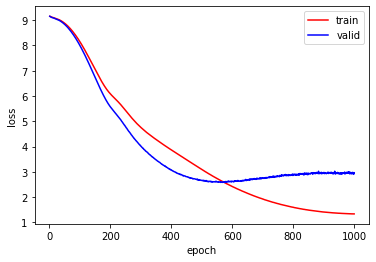

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig('./output/loss.png')